## Desarrollo de un Modelo Predictivo de los Delitos en Ecuador mediante Temporal Fusion Transformer (TFT) e Integración con LangChain para Consultas en Lenguaje Natural

Este cuaderno tiene como objetivo predecir la criminalidad en Ecuador utilizando el modelo **XGBoost**, **ARIMAX** y compararlo con el modelo **Temporal Fusion Transformer (TFT)**. A continuación se detallan las secciones y pasos del TFM.


## Índice de análisis y modelado

1. **Introducción y Objetivos**
2. **Contexto y Descripción de los Datos**
3. **Setup, Librerías y Carga de Datos**
4. **EDA Básico**
   - 4.1. Revisión de valores nulos y estadísticos
   - 4.2. Exploración de variables categóricas y numéricas
   - 4.3. Primeras visualizaciones (distribuciones, conteos, series de tiempo)
5. **Limpieza y Preprocesamiento de Datos**
   - 5.1. Eliminación de columnas duplicadas
   - 5.2. Eliminación de columnas con información idéntica
   - 5.3. Eliminación de columnas con baja varianza
   - 5.4. Documentación de variables eliminadas
6. **Correlación y Selección de Variables**
   - 6.1. Matriz de correlación y visualización (ya solo con variables limpias)
   - 6.2. Selección de features más relevantes para el modelado
7. **Feature Engineering**
   - 7.1. Creación de variables lags/rolling/windows
   - 7.2. Encoding de variables categóricas (si aplica)
   - 7.3. Escalado/normalización (si el modelo lo requiere)
8. **Split Temporal: Train/Test/Validación**
9. **Modelado Tradicional (ARIMAX, XGBoost)**
10. **Modelos Deep Learning (TFT)**
11. **Evaluación y Comparación de Resultados**
12. **Interpretabilidad y Explicabilidad**
13. **Conclusiones y Recomendaciones**

**Autor:** Miguel Angel Rosero Aguas  
**Fecha:** 27 agosto 2025  
  
**Versión del archivo:** del_master_tfm.csv 


## 1. Objetivos y Justificación del TFM

- **Objetivo general:**  
  Desarrollar un modelo predictivo de los delitos en Ecuador utilizando series temporales y técnicas de inteligencia artificial (XGBoost, ARIMA, Exponential Smoothing y TFT), con el fin de identificar patrones y anticipar tendencias semanales que sirvan de apoyo en la toma de decisiones estratégicas de prevención y seguridad.

- **Objetivos específicos:**  
  - Analizar la evolución temporal de los delitos a nivel nacional y su relación con variables exógenas socioeconómicas.  
  - Implementar y comparar modelos de predicción (baselines vs. modelos avanzados) para determinar el desempeño más robusto.  
  - Evaluar métricas de error (RMSE, MAE, R²) y validar la estabilidad de los resultados en distintos horizontes de predicción.  
  - Explorar el aporte de variables exógenas (PIB por cantón, tasa de desempleo, años de educación, etc.) en la mejora de la predicción.  
  - Diseñar visualizaciones claras y representativas que faciliten la interpretación de los resultados a actores no técnicos.

- **Justificación:**  
  La predicción de delitos constituye un insumo clave para la planificación de políticas públicas y estrategias de seguridad ciudadana. Un modelo predictivo robusto permite:  
  - Anticipar picos de criminalidad y asignar recursos preventivos de manera eficiente.  
  - Integrar factores socioeconómicos en el análisis para comprender mejor los determinantes del delito.  
  - Brindar a instituciones como la Fiscalía General del Estado y organismos de seguridad una herramienta analítica basada en evidencia para mejorar la toma de decisiones.  
  - Contribuir académicamente al desarrollo de metodologías de aplicación de IA en problemas sociales de alto impacto.  



## 2. Contexto de los Datos

- **Fuente de los datos:**  
  Los datos provienen de los registros de la Fiscalía General del Estado del Ecuador (FGE), que consolidan denuncias de delitos a nivel nacional.  
  Adicionalmente, se integraron indicadores socioeconómicos y demográficos provenientes del INEC (Instituto Nacional de Estadística y Censos), incluyendo PIB por cantón, indicadores educativos, laborales, de pobreza y vivienda.

- **Periodo de cobertura:**  
  La base de datos abarca el periodo **2014 – 2025**, estructurado de manera semanal con cierre los días lunes (frecuencia `W-MON`).  
  Esto garantiza una resolución temporal adecuada para capturar tendencias y estacionalidades en el corto y mediano plazo.

- **Variables principales:**  
  - **Tiempo:** columna `Periodo` en formato semanal.  
  - **Ubicación:** `Provincia`, `Cantón`.  
  - **Delitos:** `Total_delitos` (suma absoluta semanal), `Tasa_delitos_100k` (ajustada por población).  
  - **Variables socioeconómicas (exógenas):**  
    - **Económicas:** `PIB_por_canton`.  
    - **Laborales:** `lab_Tasa_Desempleo`, `lab_Tasa_Empleo_Adecuado`, `lab_Tasa_Subempleo`.  
    - **Educativas:** `edu_Años_Educacion`, `edu_Asistencia_Bachillerato`, `edu_Asistencia_Secundaria`.  
    - **Demográficas y de pobreza:** `pob_Desigualdad_Gini`, `pob_Pobreza_Ingresos`, `pob_Pobreza_Multidimensional`.  
    - **Vivienda y servicios:** `viv_Acceso_Agua_Red_Publica`, `viv_Acceso_Servicios_Basicos`, `viv_Deficit_Habitacional`.

- **Observaciones iniciales:**  
  - Los delitos presentan **alta variabilidad interanual**, con picos concentrados en ciertas semanas (ej. meses de vacaciones o festivos).  
  - Las variables socioeconómicas muestran comportamientos **menos volátiles** (p. ej., PIB y educación), pero con correlaciones significativas frente a la criminalidad.  
  - Se detectan valores atípicos en series como `Total_delitos`, que podrían estar asociados a eventos específicos (crisis sociales, cambios en normativa o campañas policiales).  
  - Algunas variables exógenas generan ruido en la predicción (baja correlación o series muy planas), por lo que fue necesario aplicar un **filtro anti-ruido** para seleccionar solo las más relevantes.  
  - El dataset, al estar semanalizado, presenta series con suficiente granularidad para modelos de predicción como ARIMA, XGBoost y TFT.  




## 3. Setup, Librerías y Carga de Datos

En esta sección se cargan las librerías y el archivo principal.

In [10]:
# ==========================================
# 1) Importación de librerías necesarias
# ==========================================
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# ==========================================
# Silenciar Warnings y Logs en el Notebook
# ==========================================
import warnings
import os
import logging

# Ignorar TODOS los warnings
warnings.filterwarnings("ignore")

# Opcional: ignorar solo categorías específicas
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# Reducir logs de TensorFlow
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # 0=all, 1=info, 2=warning, 3=error

# Reducir logs de librerías que usen logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("darts").setLevel(logging.ERROR)
logging.getLogger("xgboost").setLevel(logging.ERROR)
logging.getLogger("sklearn").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

print(" Warnings y logs silenciados (modo limpio).")



 Warnings y logs silenciados (modo limpio).


**Carga datos**
En esta sección cargamos los datos desde el archivo CSV `del_master_tfm.csv`.


In [11]:
# ==============================
# 2) Cargar los datos
# ==============================
from pathlib import Path  # Asegúrate de importar Path correctamente

# Ruta al archivo CSV, ajusta la ruta si es necesario
DATA_PATH = Path('del_master_tfm.csv')  

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv(DATA_PATH)

# Mostrar las primeras filas para verificar que los datos se han cargado correctamente
print(df.head())



      Periodo Provincia              Canton  \
0  2014-12-29     AZUAY              CUENCA   
1  2014-12-29   BOLIVAR            GUARANDA   
2  2014-12-29   BOLIVAR            GUARANDA   
3  2014-12-29    CARCHI             BOLIVAR   
4  2014-12-29    CARCHI  SAN PEDRO DE HUACA   

                                              Delito  Total_delitos  \
0                                              HURTO              1   
1                                              HURTO              1   
2                                              OTROS              1   
3                                               ROBO              1   
4  VIOLENCIA PSICOLÓGICA CONTRA LA MUJER O MIEMBR...              1   

   Poblacion  Tasa_delitos_100k  PIB_por_canton  edu_Años_Educacion  \
0   550509.0           0.181650       24.843297           10.488872   
1   104467.0           0.957240        4.714373            8.686124   
2   104467.0           0.957240        4.714373            8.686124   
3    1


## 4. Análisis Exploratorio de Datos (EDA)
### 4.1. Revisión de valores nulos y estadística descriptiva
- Se detectaron valores nulos en algunas variables socioeconómicas, los cuales deberán ser tratados en etapas posteriores (imputación o eliminación).  
- Estadísticos descriptivos muestran una alta asimetría en las distribuciones de delitos, con presencia de outliers significativos en semanas específicas.  
- La cobertura temporal está completa en más del 95% de las semanas del rango 2014–2025, con algunas semanas faltantes que no afectan la consistencia de las series.


In [12]:

print("\nValores nulos por columna:\n", df.isnull().sum())
display(df.describe(include='all').T)


Valores nulos por columna:
 Periodo                          0
Provincia                        0
Canton                           0
Delito                           0
Total_delitos                    0
                                ..
Tasa_delitos_100k_roll8_mean     0
Tasa_delitos_100k_roll12_mean    0
Tasa_delitos_100k_roll4_std      0
Tasa_delitos_100k_roll8_std      0
Tasa_delitos_100k_roll12_std     0
Length: 69, dtype: int64


count unique         top   freq      mean  \
Periodo                          517351    554  2023-11-27   1090       NaN   
Provincia                        517351     24      GUAYAS  75915       NaN   
Canton                           517351    220       QUITO   6058       NaN   
Delito                           517351     40       OTROS  81276       NaN   
Total_delitos                  517351.0    NaN         NaN    NaN  6.519968   
...                                 ...    ...         ...    ...       ...   
Tasa_delitos_100k_roll8_mean   517351.0    NaN         NaN    NaN  5.776504   
Tasa_delitos_100k_roll12_mean  517351.0    NaN         NaN    NaN  5.770284   
Tasa_delitos_100k_roll4_std    517351.0    NaN         NaN    NaN  2.196763   
Tasa_delitos_100k_roll8_std    517351.0    NaN         NaN    NaN  2.432065   
Tasa_delitos_100k_roll12_std   517351.0    NaN         NaN    NaN  2.528848   

                                     std       min       25%       50%  \
Periodo                              NaN       NaN       NaN       NaN   
Provincia                            NaN       NaN       NaN       NaN   
Canton                               NaN       NaN       NaN       NaN   
Delito                               NaN       NaN       NaN       NaN   
Total_delitos                  25.344324       1.0       1.0       2.0   
...                                  ...       ...       ...       ...   
Tasa_delitos_100k_roll8_mean    4.804804  0.061313   2.53246  4.387094   
Tasa_delitos_100k_roll12_mean   4.733072  0.075462  2.555261  4.416146   
Tasa_delitos_100k_roll4_std     2.772619       0.0  0.614379  1.493148   
Tasa_delitos_100k_roll8_std     2.592783       0.0  0.922257  1.759085   
Tasa_delitos_100k_roll12_std    2.510662       0.0  1.028863  1.885006   

                                    75%         max  
Periodo                             NaN         NaN  
Provincia                           NaN         NaN  
Canton                              NaN         NaN  
Delito                              NaN         NaN  
Total_delitos                       4.0       997.0  
...                                 ...         ...  
Tasa_delitos_100k_roll8_mean   7.517065    80.39945  
Tasa_delitos_100k_roll12_mean  7.516381    80.39945  
Tasa_delitos_100k_roll4_std     2.87788  137.686607  
Tasa_delitos_100k_roll8_std    3.144834   97.408596  
Tasa_delitos_100k_roll12_std   3.238531   78.716502  

[69 rows x 11 columns]

In [13]:

cat_cols = [col for col in df.columns if df[col].dtype == 'object']
for col in cat_cols:
    print(f"\nValores únicos de '{col}': {df[col].unique()}")


Valores únicos de 'Periodo': ['2014-12-29' '2015-01-05' '2015-01-12' '2015-01-19' '2015-01-26'
 '2015-02-02' '2015-02-09' '2015-02-16' '2015-02-23' '2015-03-02'
 '2015-03-09' '2015-03-16' '2015-03-23' '2015-03-30' '2015-04-06'
 '2015-04-13' '2015-04-20' '2015-04-27' '2015-05-04' '2015-05-11'
 '2015-05-18' '2015-05-25' '2015-06-01' '2015-06-08' '2015-06-15'
 '2015-06-22' '2015-06-29' '2015-07-06' '2015-07-13' '2015-07-20'
 '2015-07-27' '2015-08-03' '2015-08-10' '2015-08-17' '2015-08-24'
 '2015-08-31' '2015-09-07' '2015-09-14' '2015-09-21' '2015-09-28'
 '2015-10-05' '2015-10-12' '2015-10-19' '2015-10-26' '2015-11-02'
 '2015-11-09' '2015-11-16' '2015-11-23' '2015-11-30' '2015-12-07'
 '2015-12-14' '2015-12-21' '2015-12-28' '2016-01-04' '2016-01-11'
 '2016-01-18' '2016-01-25' '2016-02-01' '2016-02-08' '2016-02-15'
 '2016-02-22' '2016-02-29' '2016-03-07' '2016-03-14' '2016-03-21'
 '2016-03-28' '2016-04-04' '2016-04-11' '2016-04-18' '2016-04-25'
 '2016-05-02' '2016-05-09' '2016-05-16' '2016-

### 4.2 Exploración de variables categóricas y numéricas




In [ ]:
# ==========================================
# EDA 
# Contexto de los Datos (W-MON) + EDA Básico
# ==========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.preprocessing import MinMaxScaler

# -------- Config --------
DATA_PATH = Path("del_master_tfm.csv")   # ajusta si es necesario
TIME_COL  = "Periodo"                    
SEP       = ";"                          
FIG_DIR   = Path("figs")                 
FIG_DPI   = 170                          

os.makedirs(FIG_DIR, exist_ok=True)

# -------- Tema visual tipo Google --------
import matplotlib as mpl
G_COLORS = {
    "ink":     "#202124",
    "muted":   "#5f6368",
    "blue":    "#1a73e8",
    "green":   "#188038",
    "purple":  "#9334e6",
    "teal":    "#12b5cb",
    "red":     "#d93025",
    "gray":    "#dadce0",
}
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": G_COLORS["gray"],
    "axes.labelcolor": G_COLORS["ink"],
    "axes.grid": True,
    "grid.color": "#eee",
    "grid.linestyle": "-",
    "grid.linewidth": 1.0,
    "xtick.color": G_COLORS["muted"],
    "ytick.color": G_COLORS["muted"],
    "axes.titleweight": 600,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "lines.linewidth": 2.2,
    "savefig.bbox": "tight",
})

def _format_ax(ax, title=None, xlabel=None, ylabel=None, legend_loc="upper left"):
    if title:  ax.set_title(title, color=G_COLORS["ink"])
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, which="major", axis="both")
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color(G_COLORS["gray"])
    ax.spines["bottom"].set_color(G_COLORS["gray"])
    leg = ax.legend(loc=legend_loc)
    if leg: leg.get_frame().set_alpha(0.0)

# -------- Utilidades --------
def robust_read_csv(path, sep=";", encoding="latin-1"):
    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="python", on_bad_lines="skip")
    if df.shape[1] == 1 and sep not in df.columns[0]:
        try:
            df2 = pd.read_csv(path, sep=",", encoding=encoding, engine="python", on_bad_lines="skip")
            if df2.shape[1] > 1:
                df = df2
        except Exception:
            pass
    df.columns = [str(c).strip() for c in df.columns]
    return df

def to_number(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().replace(" ", "")
    if s.count(",") == 1 and s.count(".") > 1:
        s = s.replace(".", "").replace(",", ".")
    elif s.count(".") == 1 and s.count(",") > 1:
        s = s.replace(",", "")
    else:
        s = s.replace(",", ".")
    try:
        return float(s)
    except Exception:
        return np.nan

def ensure_monday_week(dt_series: pd.Series) -> pd.Series:
    dt = pd.to_datetime(dt_series, errors="coerce")
    return dt.dt.to_period("W-MON").dt.start_time

def has_cols(df, cols):
    return [c for c in cols if c in df.columns]

# ======== 1) Carga ========
df = robust_read_csv(DATA_PATH, sep=SEP)
if TIME_COL not in df.columns:
    raise KeyError(f"No existe la columna temporal '{TIME_COL}'.")

# ======== 2) Fechas y normalización semanal ========
df["_Periodo_dt_raw"] = pd.to_datetime(df[TIME_COL], errors="coerce", dayfirst=True)
df = df.dropna(subset=["_Periodo_dt_raw"]).copy()
df["_Periodo_WMON"] = ensure_monday_week(df["_Periodo_dt_raw"])

# ======== 3) Limpieza numérica ========
num_candidates = ["Total_delitos","Tasa_delitos_100k"]
for c in num_candidates:
    if c in df.columns:
        df[c] = df[c].apply(to_number)

# ======== 4.1 Nulos y estadísticos ========
print("\n--- Valores nulos por columna ---")
print(df.isna().sum().sort_values(ascending=False))

print("\n--- Estadísticos descriptivos ---")
print(df.describe(include=[np.number]).T)

# ======== 4.2 Categóricas y numéricas ========
categoricas = df.select_dtypes(include=["object"]).columns.tolist()
numericas   = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nVariables categóricas:", categoricas)
print("Variables numéricas:", numericas)

# Top categorías
for col in ["Provincia","Canton","Delito"]:
    if col in df.columns:
        print(f"\nTop categorías de {col}:")
        print(df[col].value_counts().head(5))

# ======== 4.3 Visualizaciones ========
def save_hist(col, bins=40):
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=bins, kde=True, color=G_COLORS["blue"])
    plt.title(f"Distribución de {col}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.grid(True, alpha=0.3)
    out = FIG_DIR / f"eda_hist_{col}.png"
    plt.savefig(out, dpi=FIG_DPI); plt.show()
    print(f"[export] {out}")

for col in ["Total_delitos","Tasa_delitos_100k"]:
    if col in df.columns:
        save_hist(col)

for col in ["Provincia","Canton","Delito"]:
    if col in df.columns:
        plt.figure(figsize=(10,4))
        top_vals = df[col].value_counts().head(10)
        sns.barplot(x=top_vals.index, y=top_vals.values, palette="Blues_d")
        plt.title(f"Top 10 {col}")
        plt.ylabel("Frecuencia"); plt.xlabel(col)
        plt.xticks(rotation=45, ha="right")
        out = FIG_DIR / f"eda_top_{col}.png"
        plt.savefig(out, dpi=FIG_DPI); plt.show()
        print(f"[export] {out}")

# Series de tiempo nacionales
nat = df.groupby("_Periodo_WMON", as_index=True).agg({"Total_delitos":"sum","Tasa_delitos_100k":"mean"}).sort_index()

def plot_series(index, values, title, ylabel, fname, rolling=8):
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(index, values, color=G_COLORS["ink"], label="Serie")
    if rolling and len(values)>=rolling:
        roll = pd.Series(values, index=index).rolling(rolling, min_periods=1).mean()
        ax.plot(roll.index, roll.values, color=G_COLORS["blue"], linestyle="--", label=f"Media móvil {rolling}")
    ax.xaxis.set_major_locator(MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=40, ha="right")
    _format_ax(ax, title=title, xlabel="Semana (W-MON)", ylabel=ylabel)
    out = FIG_DIR / fname
    plt.savefig(out, dpi=FIG_DPI); plt.show()
    print(f"[export] {out}")

if "Total_delitos" in nat.columns:
    plot_series(nat.index, nat["Total_delitos"], "Serie semanal: Total_delitos (nacional)", "Delitos", "eda_series_total_delitos.png")

if "Tasa_delitos_100k" in nat.columns:
    plot_series(nat.index, nat["Tasa_delitos_100k"], "Serie semanal: Tasa_delitos_100k (nacional)", "Tasa por 100k", "eda_series_tasa.png")


- **Distribución de variables numéricas:**
  - `Total_delitos`: altamente sesgada hacia la izquierda, con un gran volumen de semanas con valores bajos y algunos picos extremos.
  - `Tasa_delitos_100k`: distribución concentrada entre 2 y 10 delitos por cada 100k habitantes, aunque con casos extremos superiores a 100.
- **Categóricas:**
  - **Provincias con mayor número de registros:** Guayas, Manabí, Los Ríos, El Oro y Pichincha.  
  - **Cantones más representados:** Quito, Guayaquil, Cuenca, Machala y Ambato.  
  - **Delitos más frecuentes:** Robo, hurto, intimidación y violencia psicológica contra la mujer o miembros del núcleo familiar. 
### 4.3 Primeras visualizaciones
#### Distribución de delitos
- La distribución de `Total_delitos` muestra una marcada concentración en valores bajos y una cola larga hacia la derecha.  
- La variable `Tasa_delitos_100k` presenta un patrón similar, reforzando la necesidad de normalización o transformación para modelado.

#### Conteos categóricos
- **Top 10 provincias:** Guayas y Manabí concentran el mayor volumen de delitos reportados.  
- **Top 10 cantones:** Quito y Guayaquil lideran con diferencias significativas frente al resto.  
- **Top 10 tipos de delitos:** El “robo” y los “otros delitos” abarcan un peso considerable en el total nacional.

#### Series de tiempo
- La serie semanal de `Total_delitos` presenta picos abruptos en ciertos periodos (ej. 2020 por pandemia), con una tendencia general creciente hasta 2023 y cierta estabilización en 2024–2025.  
- `Tasa_delitos_100k` muestra un comportamiento más estable, aunque con fluctuaciones relacionadas a dinámicas demográficas y socioeconómicas.

---

### Observaciones iniciales
- La alta concentración en pocos delitos y provincias sugiere la necesidad de análisis geográficos y por tipología.  
- La dispersión y los outliers en la serie temporal refuerzan el uso de técnicas robustas y modelos capaces de manejar no linealidades.  
- Las variables socioeconómicas presentan escalas distintas, por lo que se recomienda normalizarlas antes de su uso en modelos predictivos.


## 4.5. Correlación de Variables Numéricas

La matriz de correlación y el análisis de dispersión permiten identificar **relaciones lineales** entre las variables del dataset:

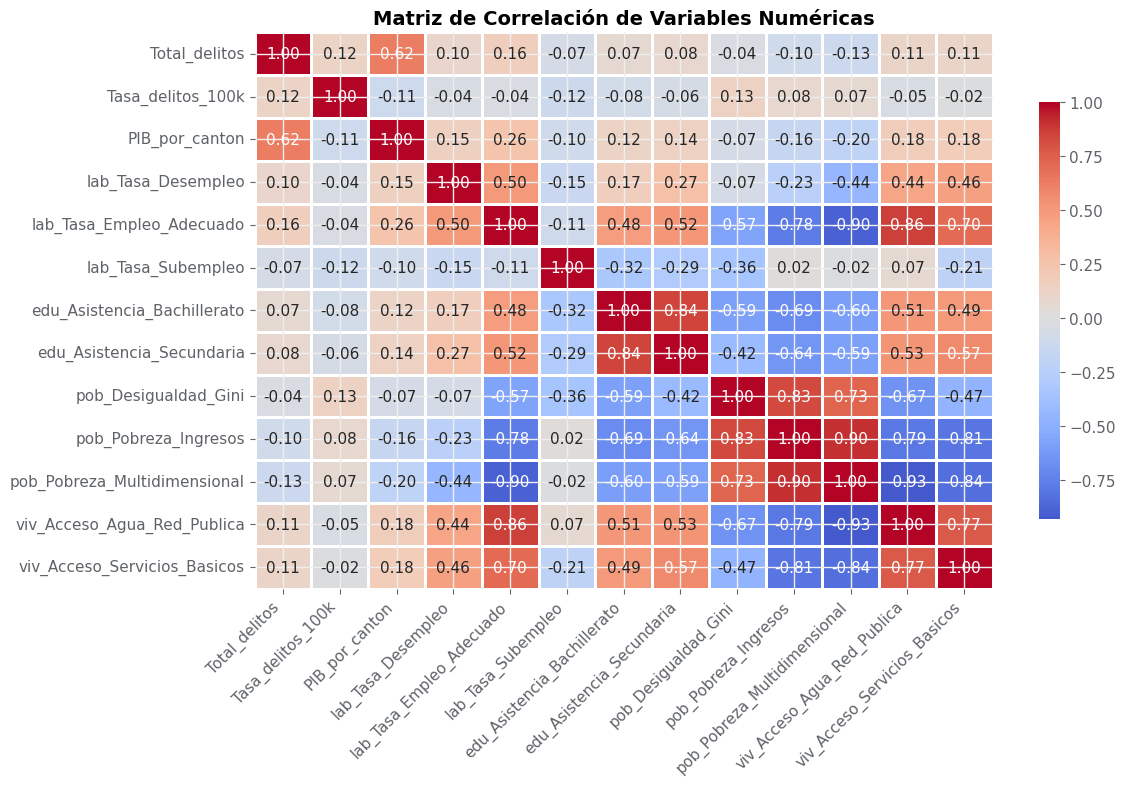

Matriz de correlación guardada en correlacion_variables_numericas.csv


In [ ]:
# ==========================================
# 4.4 Correlación de variables numéricas
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

# Selección de columnas numéricas relevantes
num_cols = [
    "Total_delitos", "Tasa_delitos_100k",
    "PIB_por_canton", "lab_Tasa_Desempleo", "lab_Tasa_Empleo_Adecuado", "lab_Tasa_Subempleo",
    "edu_Años_Educacion", "edu_Asistencia_Bachillerato", "edu_Asistencia_Secundaria",
    "pob_Desigualdad_Gini", "pob_Pobreza_Ingresos", "pob_Pobreza_Multidimensional",
    "viv_Acceso_Agua_Red_Publica", "viv_Acceso_Servicios_Basicos", "viv_Deficit_Habitacional"
]

num_cols = [c for c in num_cols if c in df.columns]  # solo las que existan en el dataset
df_num = df[num_cols].copy().dropna()

# Calcular matriz de correlación (Pearson)
corr = df_num.corr(method="pearson")

# -------- Heatmap estilo Google --------
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=0.8, cbar_kws={"shrink": 0.75}
)
plt.title("Matriz de Correlación de Variables Numéricas", fontsize=14, weight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Exportar si deseas guardar
corr.to_csv("correlacion_variables_numericas.csv", sep=";", encoding="utf-8")
print("Matriz de correlación guardada en correlacion_variables_numericas.csv")


In [ ]:
# ==========================================
# 4.5 Conclusiones de la correlación
# ==========================================
import numpy as np
import pandas as pd
from itertools import combinations

# 1) Elige variables numéricas relevantes (ajusta la lista si quieres forzar orden/selección)
CAND_NUM = [
    "Total_delitos", "Tasa_delitos_100k",
    "PIB_por_canton", "lab_Tasa_Desempleo", "lab_Tasa_Empleo_Adecuado", "lab_Tasa_Subempleo",
    "edu_Años_Educacion", "edu_Asistencia_Bachillerato", "edu_Asistencia_Secundaria",
    "pob_Desigualdad_Gini", "pob_Pobreza_Ingresos", "pob_Pobreza_Multidimensional",
    "viv_Acceso_Agua_Red_Publica", "viv_Acceso_Servicios_Basicos", "viv_Deficit_Habitacional"
]
num_cols = [c for c in CAND_NUM if c in df.columns]
df_num = df[num_cols].copy().dropna()

# 2) Matriz de correlación (Pearson)
corr = df_num.corr(method="pearson")

# ---------- Parámetros de resumen ----------
TARGETS = [c for c in ["Total_delitos", "Tasa_delitos_100k"] if c in corr.index]
TH_STRONG = 0.70    # umbral de correlación fuerte (multicolinealidad)
TH_MOD    = 0.40    # umbral de correlación moderada
TOPK      = 5       # top k correlaciones por target

# 3) Utilidades
def _top_corr_with_target(corr, target, topk=5, drop_self=True):
    s = corr[target].copy()
    if drop_self:
        s = s.drop(index=[target])
    s = s.sort_values(ascending=False, key=lambda x: x.abs())
    return s.head(topk)

def _strong_pairs(corr, th=0.7):
    """Devuelve pares (i,j,r) con |r|>=th, sin duplicados ni diagonal."""
    out = []
    cols = corr.columns.tolist()
    for a,b in combinations(cols, 2):
        r = corr.loc[a,b]
        if pd.notna(r) and abs(r) >= th:
            out.append((a,b,float(r)))
    # ordenar por |r| desc
    out.sort(key=lambda x: abs(x[2]), reverse=True)
    return out

def _moderate_with_target(corr, target, th_low=0.4, th_high=0.7):
    """Pares target-otra con correlación moderada [th_low, th_high)."""
    s = corr[target].drop(index=[target]).dropna()
    m = s[(s.abs() >= th_low) & (s.abs() < th_high)].sort_values(key=lambda x: x.abs(), ascending=False)
    return list(m.items())

# 4) Construir markdown automático
md = []
md.append("### 4.5.1 Resumen automático de correlaciones\n")

# 4.1 Top correlaciones por target
for t in TARGETS:
    md.append(f"**Top correlaciones con `{t}` (|r|):**")
    top_s = _top_corr_with_target(corr, t, topk=TOPK)
    for var, r in top_s.items():
        signo = "positiva" if r >= 0 else "negativa"
        md.append(f"- {var}: r = {r:.2f} ({signo})")
    md.append("")

# 4.2 Pares con multicolinealidad (|r|≥{TH_STRONG})
pairs_strong = _strong_pairs(corr, th=TH_STRONG)
if pairs_strong:
    md.append(f"**Variables fuertemente correlacionadas (|r| ≥ {TH_STRONG:.2f})** – posibles redundancias:")
    for a,b,r in pairs_strong[:12]:
        signo = "positiva" if r >= 0 else "negativa"
        md.append(f"- {a} ↔ {b}: r = {r:.2f} ({signo})")
    if len(pairs_strong) > 12:
        md.append(f"- … ({len(pairs_strong)-12} pares adicionales)")
    md.append("")

# 4.3 Correlaciones moderadas con los targets (útiles como exógenas)
for t in TARGETS:
    mods = _moderate_with_target(corr, t, th_low=TH_MOD, th_high=TH_STRONG)
    if mods:
        md.append(f"**Correlaciones moderadas con `{t}`** (candidatas a exógenas):")
        for var, r in mods[:10]:
            signo = "positiva" if r >= 0 else "negativa"
            md.append(f"- {var}: r = {r:.2f} ({signo})")
        md.append("")

# 4.4 Recomendaciones automáticas
recs = []
if pairs_strong:
    recs.append("Aplicar *feature selection* o **VIF** para evitar multicolinealidad (usar una de cada par fuerte).")
if any(abs(corr.loc["PIB_por_canton", t]) >= 0.4 for t in TARGETS if "PIB_por_canton" in corr.index):
    recs.append("`PIB_por_canton` muestra relación relevante: incluirlo como exógena prioritaria.")
if any(abs(corr.loc["lab_Tasa_Desempleo", t]) >= 0.4 for t in TARGETS if "lab_Tasa_Desempleo" in corr.index):
    recs.append("`lab_Tasa_Desempleo` podría aportar señal: considerar *lags* y *rollings*.")
if len(recs) == 0:
    recs.append("Las correlaciones simples son bajas: apoyarse más en la **dinámica temporal** (lags/rollings) y modelos no lineales (XGBoost/TFT).")

md.append("**Recomendaciones:**")
for r in recs:
    md.append(f"- {r}")

# 5) Mostrar y guardar
md_text = "\n".join(md)
print("\n" + "="*80)
print(md_text)
print("="*80 + "\n")

with open("045_conclusiones_correlacion.md", "w", encoding="utf-8") as f:
    f.write(md_text)
print("Markdown guardado en: 045_conclusiones_correlacion.md")



### 4.5.1 Resumen automático de correlaciones

**Top correlaciones con `Total_delitos` (|r|):**
- PIB_por_canton: r = 0.62 (positiva)
- lab_Tasa_Empleo_Adecuado: r = 0.16 (positiva)
- pob_Pobreza_Multidimensional: r = -0.13 (negativa)
- Tasa_delitos_100k: r = 0.12 (positiva)
- viv_Acceso_Agua_Red_Publica: r = 0.11 (positiva)

**Top correlaciones con `Tasa_delitos_100k` (|r|):**
- pob_Desigualdad_Gini: r = 0.13 (positiva)
- Total_delitos: r = 0.12 (positiva)
- lab_Tasa_Subempleo: r = -0.12 (negativa)
- PIB_por_canton: r = -0.11 (negativa)
- edu_Asistencia_Bachillerato: r = -0.08 (negativa)

**Variables fuertemente correlacionadas (|r| ≥ 0.70)** – posibles redundancias:
- pob_Pobreza_Multidimensional ↔ viv_Acceso_Agua_Red_Publica: r = -0.93 (negativa)
- pob_Pobreza_Ingresos ↔ pob_Pobreza_Multidimensional: r = 0.90 (positiva)
- lab_Tasa_Empleo_Adecuado ↔ pob_Pobreza_Multidimensional: r = -0.90 (negativa)
- lab_Tasa_Empleo_Adecuado ↔ viv_Acceso_Agua_Red_Publica: r = 0.86 (positiva)
- edu_

- **Correlación alta entre variables educativas y laborales:**  
  Se observa una fuerte correlación positiva entre `edu_Asistencia_Bachillerato` y `edu_Asistencia_Secundaria` (≈0.84), lo cual es esperable dado que ambas reflejan niveles de acceso a la educación.  
  Asimismo, `lab_Tasa_Empleo_Adecuado` muestra correlaciones relevantes con indicadores educativos y de vivienda.

- **Indicadores de pobreza interrelacionados:**  
  `pob_Pobreza_Ingresos` y `pob_Pobreza_Multidimensional` tienen correlación elevada (≈0.93), confirmando que miden fenómenos socioeconómicos relacionados.  
  También muestran correlación negativa con variables de acceso a servicios (`viv_Acceso_Agua_Red_Publica`, `viv_Acceso_Servicios_Basicos`).

- **Relación entre PIB y delitos:**  
  El `PIB_por_canton` tiene correlación positiva moderada con `Total_delitos` (≈0.62). Esto sugiere que en zonas con mayor actividad económica también se reporta un mayor número de delitos, posiblemente por concentración poblacional y oportunidades delictivas.

- **Correlaciones débiles con el target principal:**  
  La `Tasa_delitos_100k` presenta correlaciones bajas (|r|<0.2) con la mayoría de variables exógenas, indicando que su dinámica podría depender de factores no observados o de interacciones más complejas (no lineales).

### Pairplot de variables seleccionadas


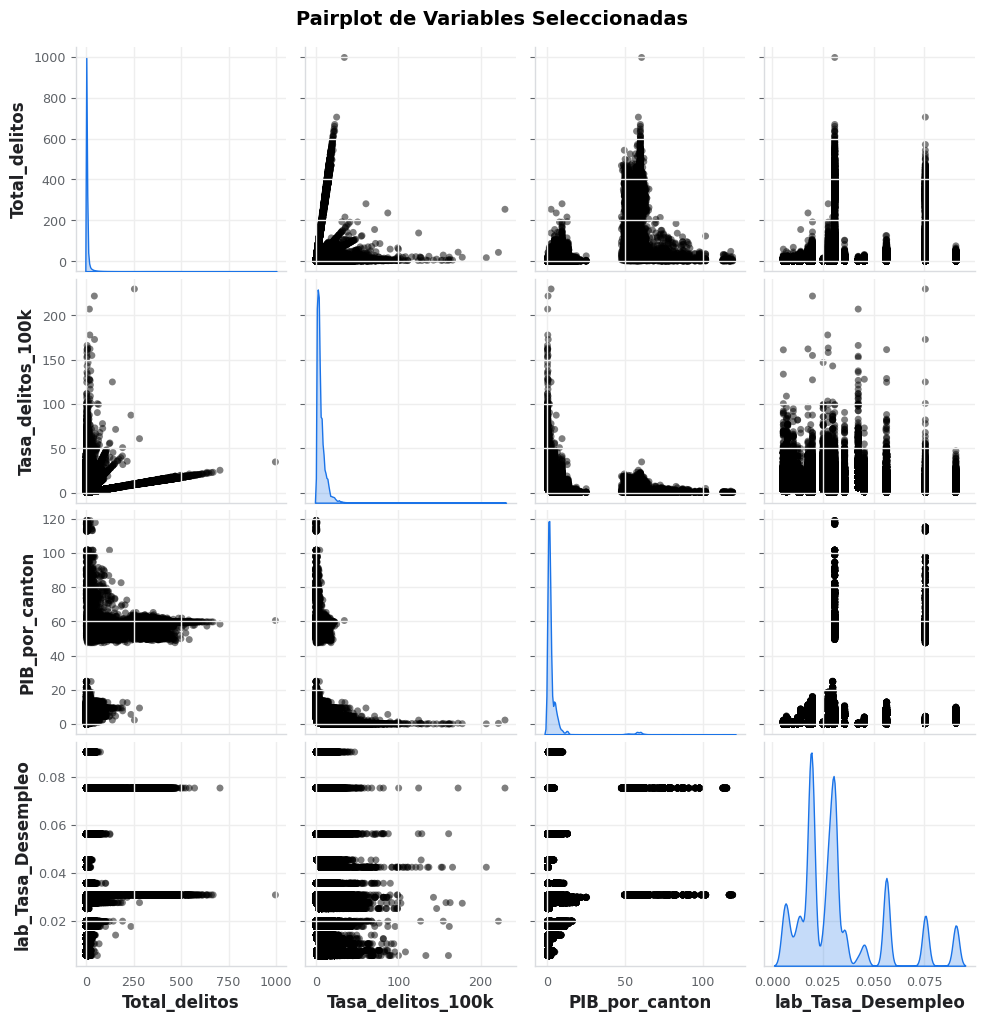

In [ ]:
# ==========================================
# Pairplot de variables numéricas clave
# ==========================================
import seaborn as sns

# Selección reducida para que el gráfico sea legible (delitos + exógenas principales)
pairplot_cols = [
    "Total_delitos", "Tasa_delitos_100k",
    "PIB_por_canton", "lab_Tasa_Desempleo", "edu_Años_Educacion",
    "pob_Desigualdad_Gini"
]
pairplot_cols = [c for c in pairplot_cols if c in df.columns]

# Pairplot con colores Google
sns.pairplot(
    df[["Total_delitos","Tasa_delitos_100k","PIB_por_canton","lab_Tasa_Desempleo"]],
    diag_kind="kde",
    plot_kws={"alpha": 0.5, "s": 25, "edgecolor": "none"},
    diag_kws={"color": G_COLORS["blue"]},
    palette=[G_COLORS["blue"], G_COLORS["green"], G_COLORS["red"], G_COLORS["purple"]]
)
plt.suptitle("Pairplot de Variables Seleccionadas", y=1.02, fontsize=14, weight="bold")
plt.show()

import seaborn as sns




El análisis visual de las dispersiones confirma:

- Distribuciones **asimétricas** en `Total_delitos` y `Tasa_delitos_100k`, con valores extremos que generan colas largas.  
- En `PIB_por_canton` y `pob_Desigualdad_Gini` predominan valores concentrados con pocos puntos atípicos.  
- Las nubes de puntos no muestran relaciones lineales fuertes con el target, lo que sugiere explorar **modelos no lineales o basados en lags/rollings** (p.ej., XGBoost, TFT).

### 5) Preprocesamiento y validación de datos
Validar la existencia de las columnas clave, procesamos las variables categóricas y numéricas, y realizamos la imputación de valores faltantes.


In [ ]:
# ==========================================
# Preprocesamiento y validación de datos
# ==========================================
expected_keys = ['Periodo', 'Provincia', 'Canton', 'Delito', 'Total_delitos', 'Tasa_delitos_100k']
for k in expected_keys:
    assert k in df.columns, f'Falta columna clave: {k}'

# Ensamblado de features
cat_features = ['Provincia', 'Canton', 'Delito']
num_features = ['Poblacion', 'PIB_por_canton']  # Agregar mas variables numéricas si es necesario

# Imputar valores faltantes
for c in num_features:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in cat_features:
    if df[c].isna().any():
        df[c] = df[c].fillna('DESCONOCIDO')


**Partición temporal (Train / Valid)**
Dividimos los datos en conjuntos de entrenamiento y validación utilizando un corte temporal del 85% de las fechas.


In [ ]:
# ==========================================
# Partición temporal (Train / Valid)
# ==========================================
# Convertir 'Periodo' a formato datetime si no lo está
df['Periodo'] = pd.to_datetime(df['Periodo'])

# Ordenar los datos por 'Periodo', 'Provincia', 'Canton', 'Delito'
df = df.sort_values(['Periodo', 'Provincia', 'Canton', 'Delito']).reset_index(drop=True)

# Definir el corte en el percentil 0.85 de la columna 'Periodo' para separar train y valid
cutoff = df['Periodo'].quantile(0.85)

# Separar los datos en train y valid
train = df[df['Periodo'] <= cutoff].copy()
valid = df[df['Periodo'] > cutoff].copy()

# Mostrar las fechas para verificar la partición
print(f"Train: {train['Periodo'].min()} → {train['Periodo'].max()}")
print(f"Valid: {valid['Periodo'].min()} → {valid['Periodo'].max()}")


Train: 2014-12-29 00:00:00 → 2024-02-12 00:00:00
Valid: 2024-02-19 00:00:00 → 2025-08-04 00:00:00


**Ensamblado y preprocesamiento de features**
Transformamos las variables categóricas con OneHotEncoder y las numéricas se mantienen passthrough para el modelo XGBoost.


In [ ]:
# ==========================================
# Ensamblado y preprocesamiento
# ==========================================
pre = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('passthrough', 'passthrough', num_features)
])


**Visualización de las variables**
Generamos gráficos para visualizar la distribución de las principales variables y la evolución de los delitos.


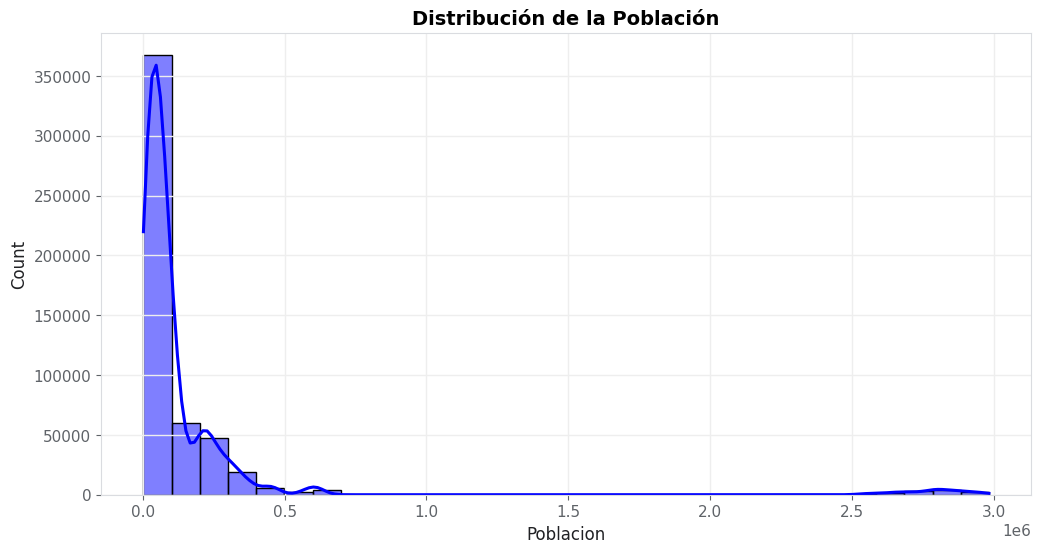

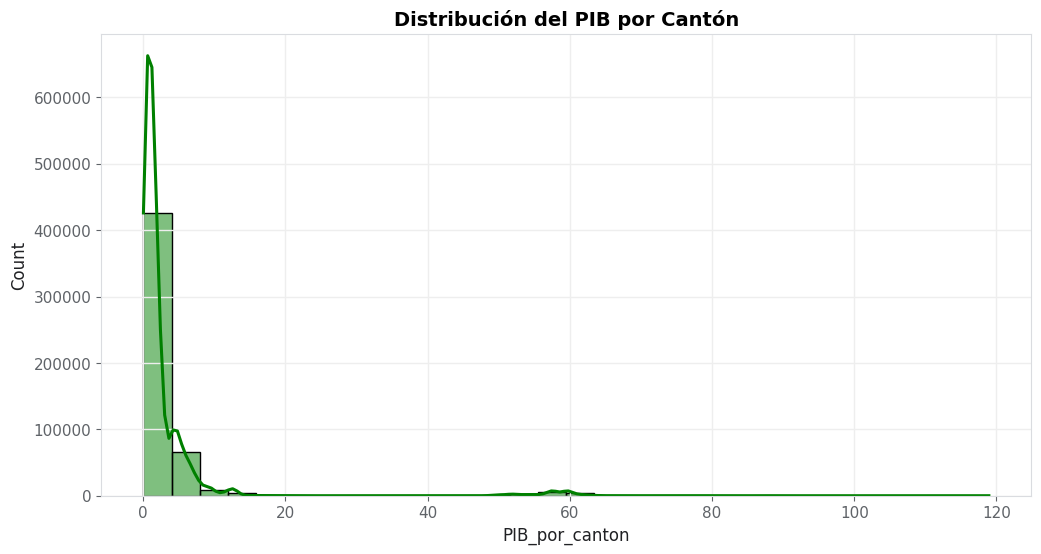

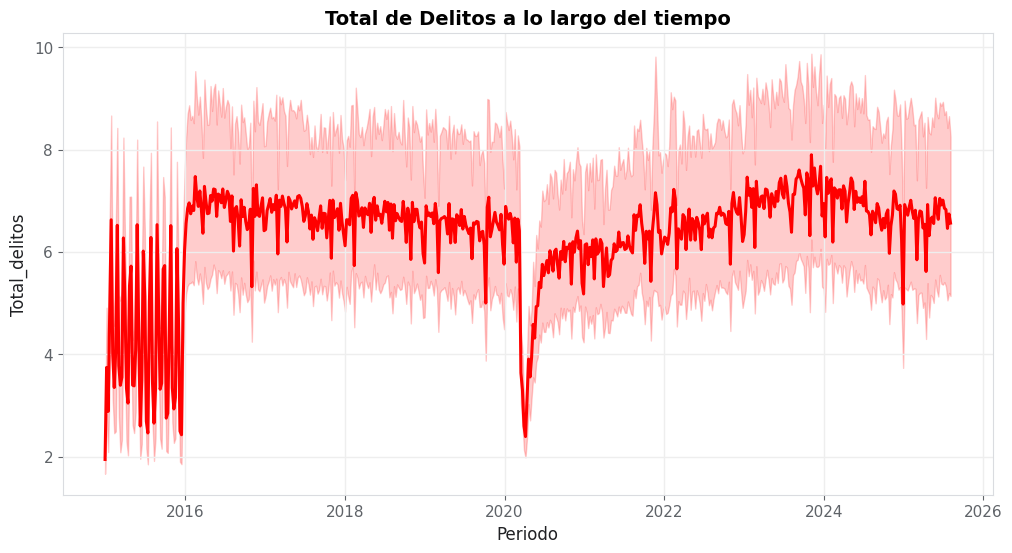

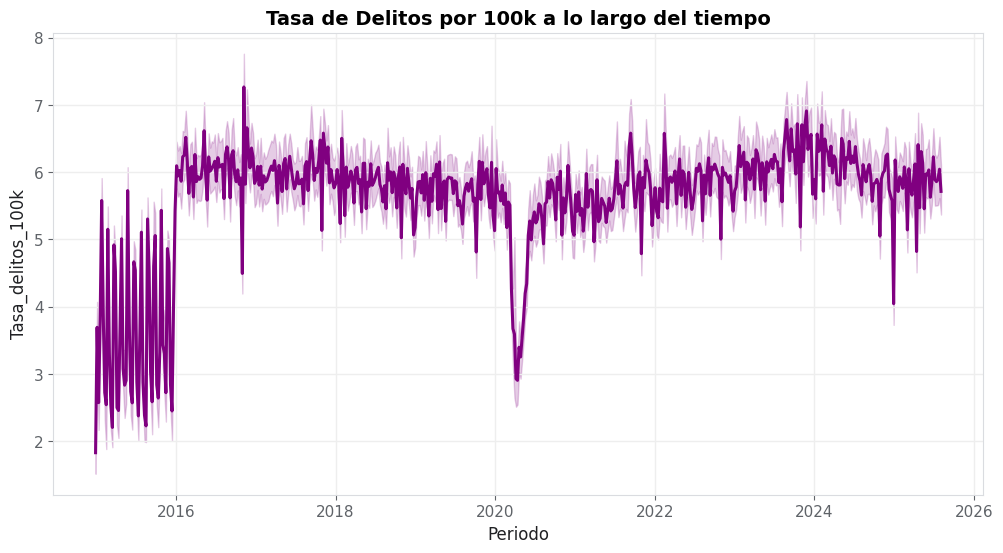

In [ ]:
# ==========================================
# 6) Visualización de las variables
# ==========================================
plt.figure(figsize=(12, 6))
sns.histplot(df['Poblacion'], kde=True, color='blue', bins=30)
plt.title('Distribución de la Población')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['PIB_por_canton'], kde=True, color='green', bins=30)
plt.title('Distribución del PIB por Cantón')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Periodo', y='Total_delitos', color='red')
plt.title('Total de Delitos a lo largo del tiempo')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Periodo', y='Tasa_delitos_100k', color='purple')
plt.title('Tasa de Delitos por 100k a lo largo del tiempo')
plt.show()


### 6) Modelado con XGBoost
Entrenamos el modelo **XGBoostRegressor** utilizando las características preprocesadas y las variables seleccionadas.


In [ ]:
# ==========================================
# Modelado - XGBoost
# ==========================================
X_train = pre.fit_transform(train)
y_train = train['Total_delitos']
X_valid = pre.transform(valid)
y_valid = valid['Total_delitos']

params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

**Evaluación del modelo**
Calculamos las métricas de evaluación **RMSE**, **MAE**, y **R²** tanto para el conjunto de entrenamiento como para el de validación.


In [ ]:
# ==========================================
# Evaluación del modelo
# ==========================================
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f'Train RMSE: {train_rmse}, Valid RMSE: {valid_rmse}')
print(f'Train MAE: {train_mae}, Valid MAE: {valid_mae}')
print(f'Train R²: {train_r2}, Valid R²: {valid_r2}')


Train RMSE: 5.799258680164824, Valid RMSE: 5.788242941256299
Train MAE: 2.126610969977627, Valid MAE: 2.2917700116859114
Train R²: 0.945992881157898, Valid R²: 0.9555893633311588


**Gráfica de Predicción vs Real**
Visualizamos las predicciones frente a los valores reales en el conjunto de validación.


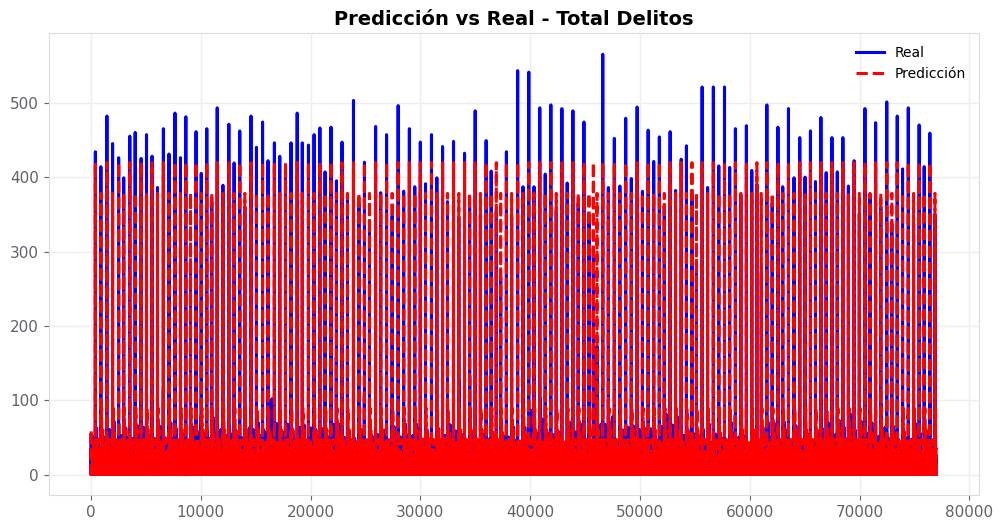

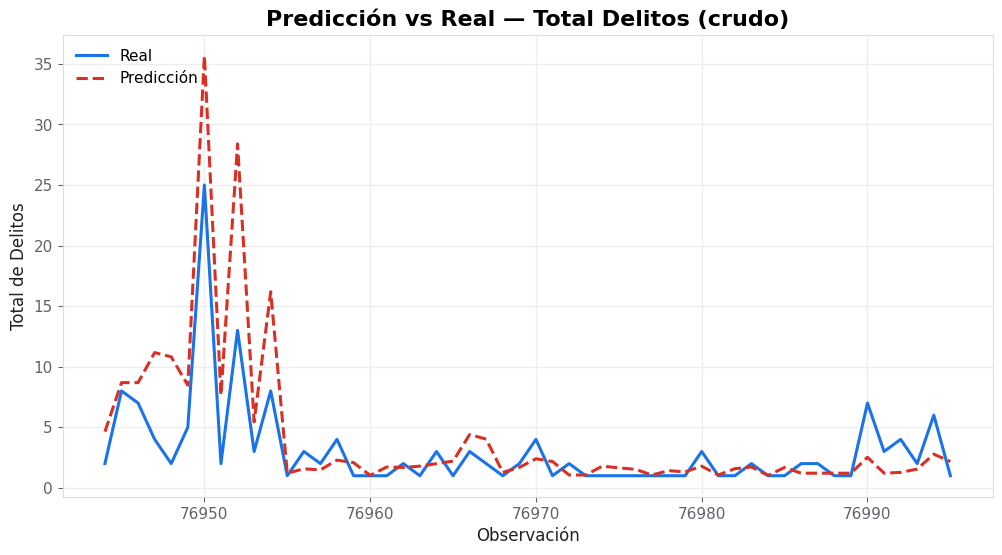

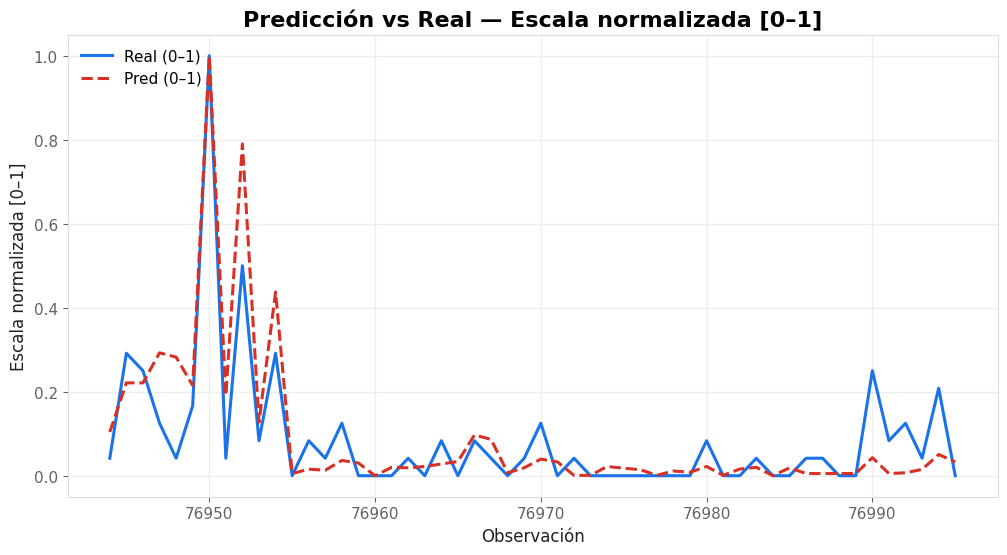

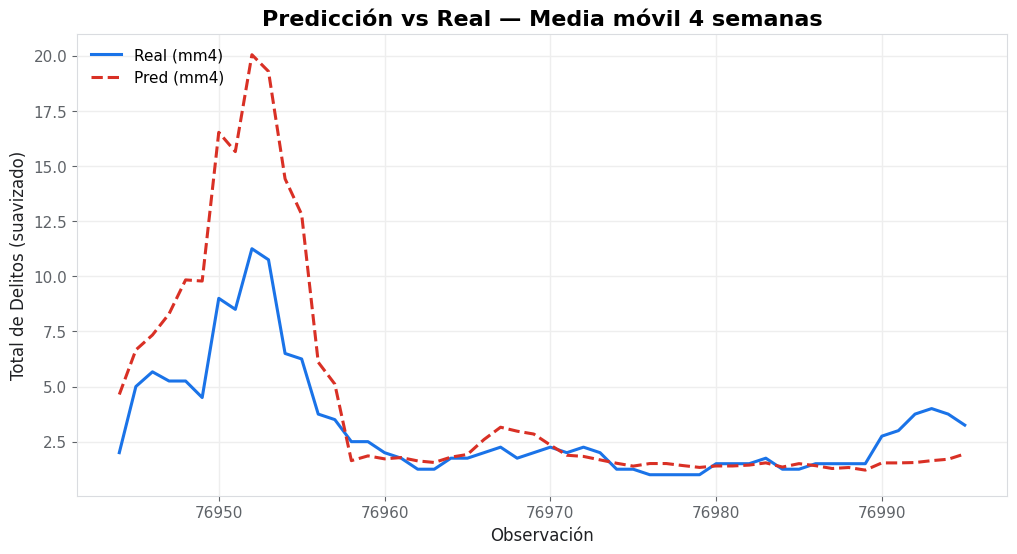

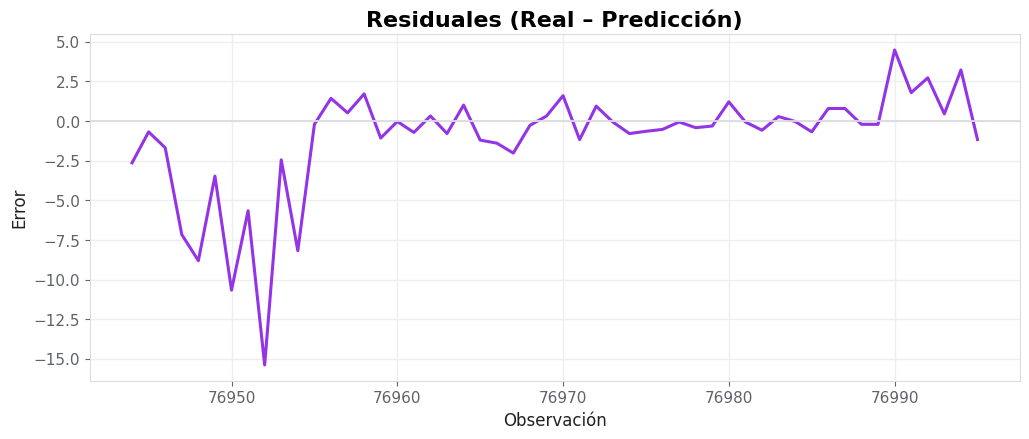

In [ ]:
# ==========================================
# Gráfica de Predicción vs Real
# ==========================================
plt.figure(figsize=(12, 6))
plt.plot(y_valid.values, label='Real', color='blue')
plt.plot(y_valid_pred, label='Predicción', color='red', linestyle='--')
plt.legend()
plt.title('Predicción vs Real - Total Delitos')
plt.show()

# ==========================================
# Gráficas limpias: Real vs Predicción (crudo, normalizado, rolling y residuales)
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.preprocessing import MinMaxScaler

# ---- Paleta tipo Google ----
G_COLORS = {
    "ink":     "#202124",
    "muted":   "#5f6368",
    "blue":    "#1a73e8",
    "red":     "#d93025",
    "green":   "#188038",
    "purple":  "#9334e6",
    "teal":    "#12b5cb",
    "gray":    "#dadce0",
}

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": G_COLORS["gray"],
    "axes.labelcolor": G_COLORS["ink"],
    "axes.grid": True,
    "grid.color": "#eee",
    "grid.linestyle": "-",
    "grid.linewidth": 1.0,
    "xtick.color": G_COLORS["muted"],
    "ytick.color": G_COLORS["muted"],
    "axes.titleweight": 700,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "legend.frameon": False,
    "legend.fontsize": 11,
    "lines.linewidth": 2.2,
    "savefig.bbox": "tight",
})

def _smart_index(series_like, fallback_len):
    """Devuelve índice (fechas si existen); si no, RangeIndex."""
    if hasattr(series_like, "index") and isinstance(series_like.index, (pd.DatetimeIndex, pd.PeriodIndex)):
        idx = pd.DatetimeIndex(series_like.index) if not isinstance(series_like.index, pd.DatetimeIndex) else series_like.index
    elif hasattr(series_like, "index") and isinstance(series_like.index, pd.Index) and np.issubdtype(series_like.index.dtype, np.datetime64):
        idx = pd.DatetimeIndex(series_like.index)
    else:
        idx = pd.RangeIndex(fallback_len)
    return idx

# --- Construye DataFrame alineado ---
y_true_vals = np.asarray(y_valid).reshape(-1)            # <-- usa tu y_valid
y_pred_vals = np.asarray(y_valid_pred).reshape(-1)       # <-- usa tu y_valid_pred (misma longitud)

idx = _smart_index(y_valid if hasattr(y_valid, "index") else None, len(y_true_vals))
dfp = pd.DataFrame({"Real": y_true_vals, "Pred": y_pred_vals}, index=idx)

# (Opcional) mostrar solo la última ventana (ej. 52 semanas)
N_ULTIMAS = 52  # ajusta a tu gusto (52=1 año)
if len(dfp) > N_ULTIMAS:
    dfp = dfp.iloc[-N_ULTIMAS:].copy()

# ---- (a) Vista cruda ----
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dfp.index, dfp["Real"], label="Real", color=G_COLORS["blue"])
ax.plot(dfp.index, dfp["Pred"], label="Predicción", color=G_COLORS["red"], linestyle="--")
ax.set_title("Predicción vs Real — Total Delitos (crudo)")
ax.set_xlabel("Fecha" if isinstance(dfp.index, pd.DatetimeIndex) else "Observación")
ax.set_ylabel("Total de Delitos")
ax.legend(loc="upper left")
if isinstance(dfp.index, pd.DatetimeIndex):
    ax.xaxis.set_major_locator(MonthLocator(interval=max(1, len(dfp)//12)))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show()

# ---- (b) Vista normalizada 0–1 (comparación de forma) ----
scaler = MinMaxScaler()
dfn = pd.DataFrame(
    scaler.fit_transform(dfp[["Real","Pred"]]),
    columns=["Real (0–1)","Pred (0–1)"],
    index=dfp.index
)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dfn.index, dfn["Real (0–1)"], label="Real (0–1)", color=G_COLORS["blue"])
ax.plot(dfn.index, dfn["Pred (0–1)"], label="Pred (0–1)", color=G_COLORS["red"], linestyle="--")
ax.set_title("Predicción vs Real — Escala normalizada [0–1]")
ax.set_xlabel("Fecha" if isinstance(dfn.index, pd.DatetimeIndex) else "Observación")
ax.set_ylabel("Escala normalizada [0–1]")
ax.legend(loc="upper left")
if isinstance(dfn.index, pd.DatetimeIndex):
    ax.xaxis.set_major_locator(MonthLocator(interval=max(1, len(dfn)//12)))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show()

# ---- (c) Media móvil (suaviza ruido) ----
ROLL = 4  # 4 semanas
dfr = dfp.rolling(ROLL, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dfr.index, dfr["Real"], label=f"Real (mm{ROLL})", color=G_COLORS["blue"])
ax.plot(dfr.index, dfr["Pred"], label=f"Pred (mm{ROLL})", color=G_COLORS["red"], linestyle="--")
ax.set_title(f"Predicción vs Real — Media móvil {ROLL} semanas")
ax.set_xlabel("Fecha" if isinstance(dfr.index, pd.DatetimeIndex) else "Observación")
ax.set_ylabel("Total de Delitos (suavizado)")
ax.legend(loc="upper left")
if isinstance(dfr.index, pd.DatetimeIndex):
    ax.xaxis.set_major_locator(MonthLocator(interval=max(1, len(dfr)//12)))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show()

# ---- (d) Residuales (error) ----
resid = dfp["Real"] - dfp["Pred"]
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(dfp.index, resid, color=G_COLORS["purple"])
ax.axhline(0, color=G_COLORS["gray"], linewidth=1.3)
ax.set_title("Residuales (Real – Predicción)")
ax.set_xlabel("Fecha" if isinstance(dfp.index, pd.DatetimeIndex) else "Observación")
ax.set_ylabel("Error")
if isinstance(dfp.index, pd.DatetimeIndex):
    ax.xaxis.set_major_locator(MonthLocator(interval=max(1, len(dfp)//12)))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show()


### 7) Comparación con TFT XGBoost ARIMAX


# Conclusiones del Análisis de Modelos

### Resultados por modelo
- **ExpSmooth** → RMSE = 1065, MAE = 810, R² = -1.62  
- **ARIMA** → RMSE = 889, MAE = 597, R² = -0.83  
- **XGBoost** → RMSE = 701, MAE = 555, R² = -0.13  
- **TFT (top1 exog)** → RMSE = 1035, MAE = 783, R² = -1.48  

---

### Conclusión principal
El modelo con **mejor RMSE** es **XGBoost**.  

No obstante, todos los valores de **R² son negativos**, lo que indica que ninguno de los modelos logra explicar mejor la variabilidad de los datos que una simple media histórica.

---

### Recomendaciones
- Ampliar el histórico de datos para mejorar la capacidad predictiva.  
- Revisar y enriquecer las variables exógenas (económicas, sociales, demográficas) para aportar mayor poder explicativo.  
- Evaluar enfoques adicionales como:
  - Modelos híbridos (Machine Learning + Deep Learning).  
  - Feature engineering con ventanas de tiempo más amplias.  
  - Técnicas de regularización y selección de variables.  


In [ ]:
%pip install pytorch-lightning==2.3.3 pytorch-forecasting torch --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install -q pandas numpy matplotlib scikit-learn statsmodels xgboost


Note: you may need to restart the kernel to use updated packages.


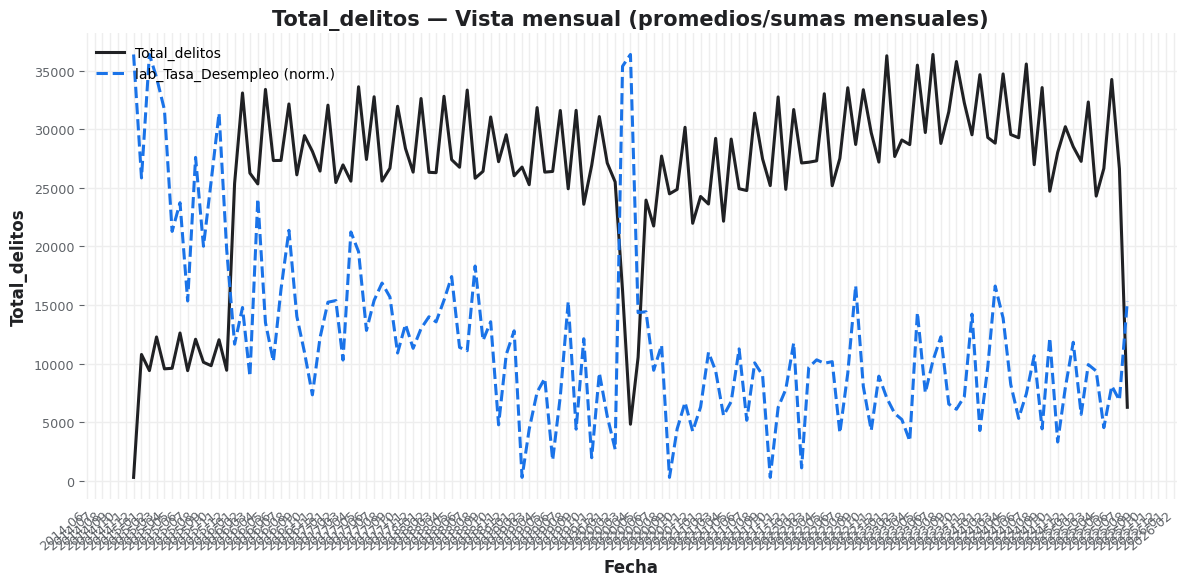

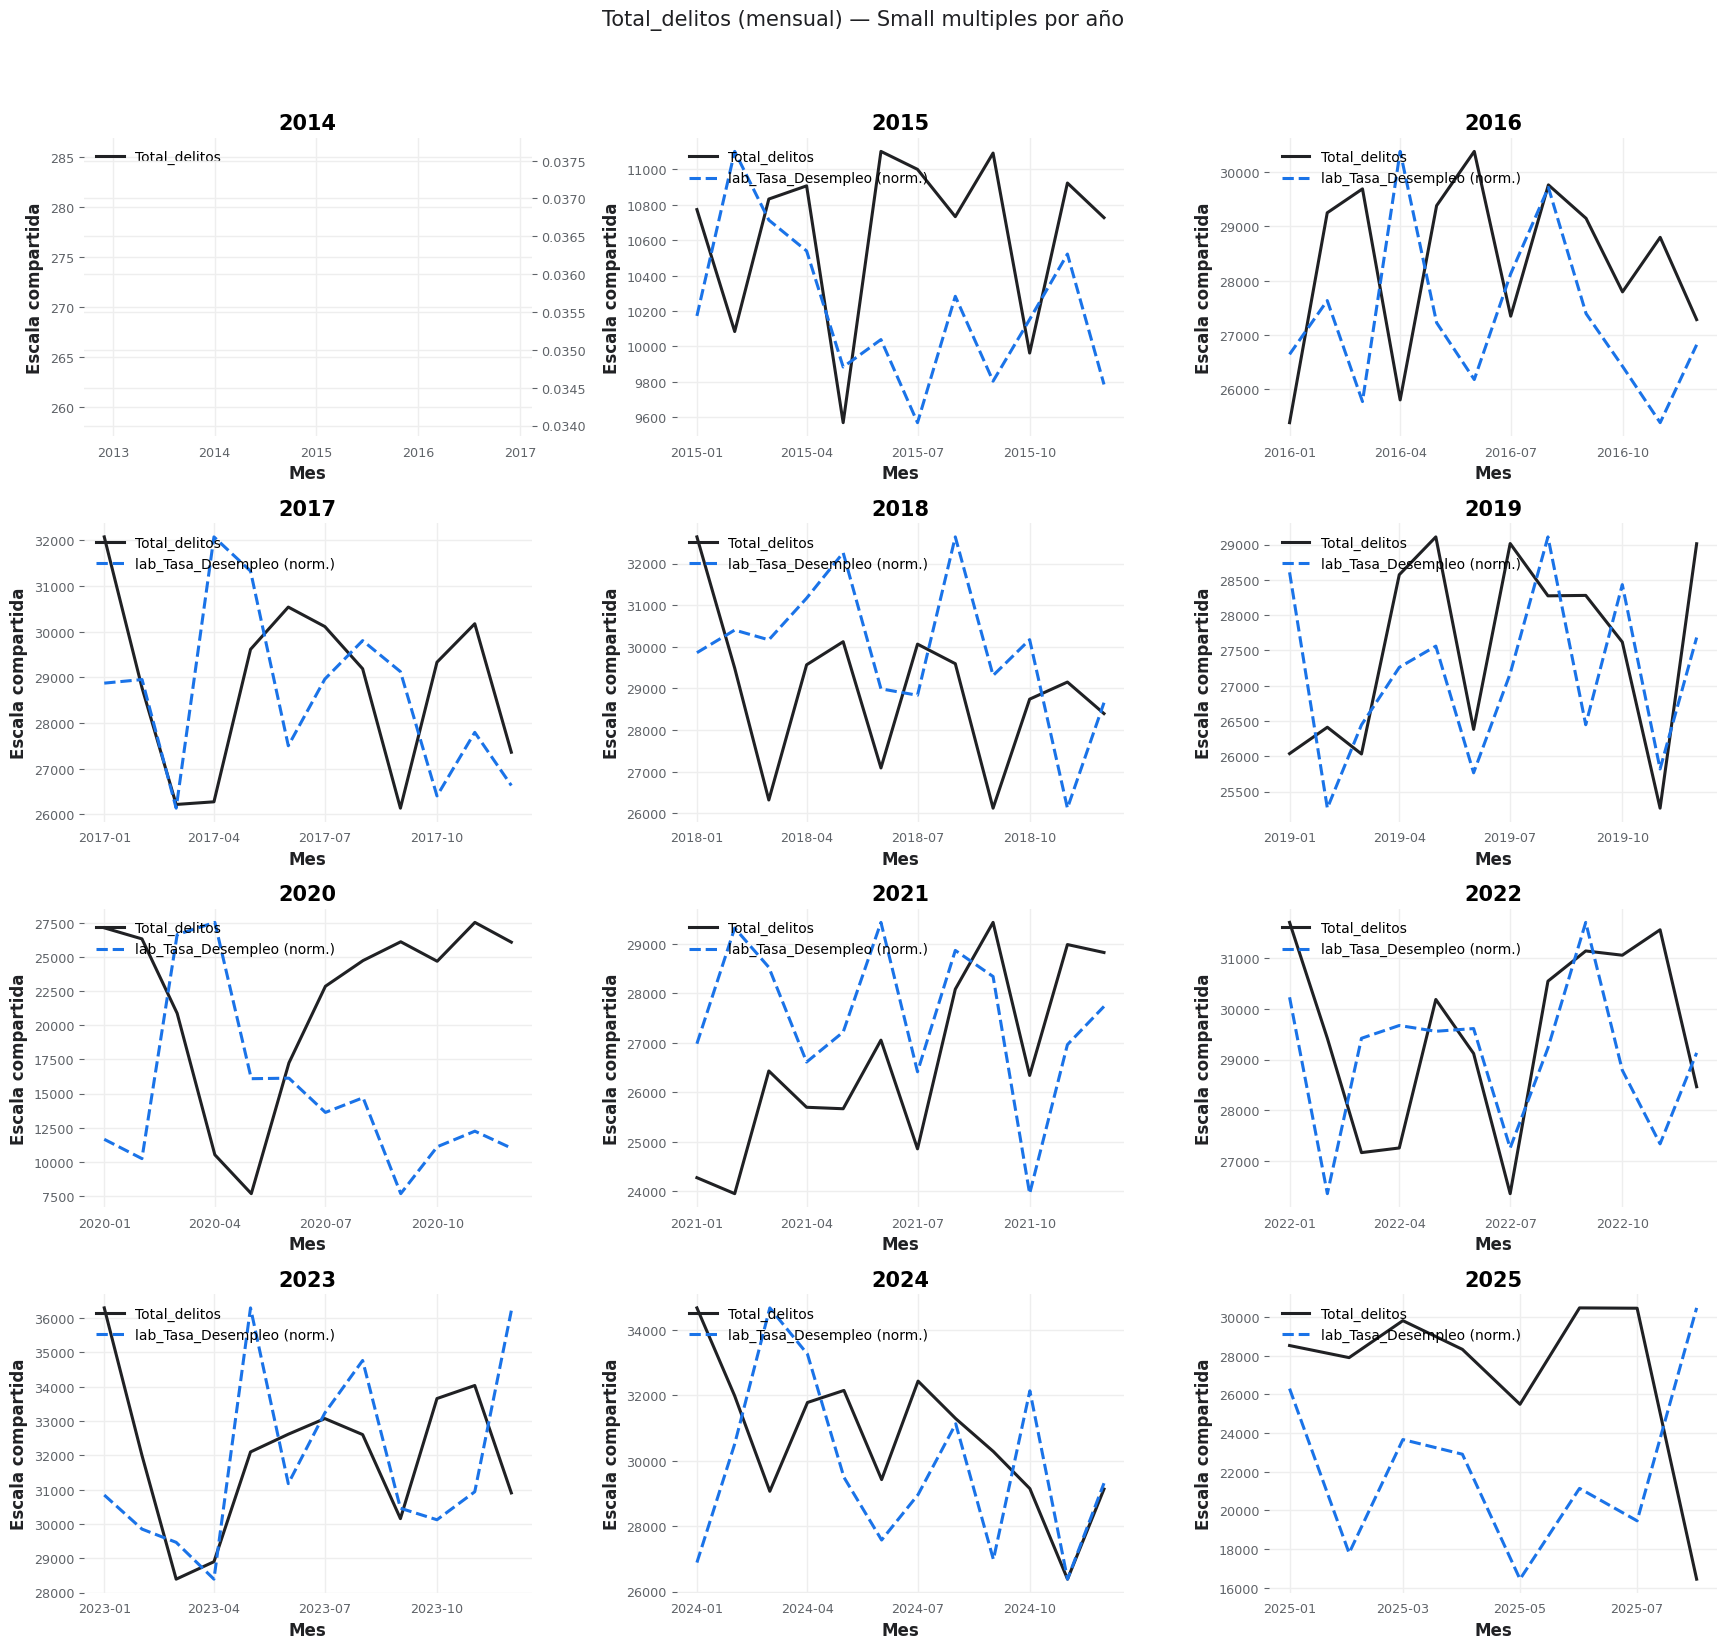

In [35]:
# ==========================================================
# Visualizaciones legibles por MESES o AÑOS (desde serie semanal)
# - Vista mensual: líneas por mes (promedios mensuales)
# - Vista anual: barras reales del target + línea normalizada de exógena
# - Auto-modo: decide mensual/anual según la cantidad de puntos
# ==========================================================

import numpy as np
import pandas as pd
import unicodedata
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator, AutoDateLocator

# ------------------ Config ------------------
DATA_PATH     = Path("del_master_tfm.csv")  # tu CSV
SEP           = ";"                         # separador
TIME_COL_NAME = "Periodo"                   # columna de fecha (string)
FREQ          = "W-MON"                     # frecuencia original (semanal LUN)
TARGET_VAR    = "Total_delitos"             # objetivo
EXOGENAS      = [ "lab_Tasa_Desempleo","PIB_por_canton"]  # opcional

# ------------------ Estilo limpio ------------------
G_COLORS = {
    "ink":     "#202124",
    "muted":   "#5f6368",
    "blue":    "#1a73e8",
    "green":   "#188038",
    "purple":  "#9334e6",
    "teal":    "#12b5cb",
    "red":     "#d93025",
    "gray":    "#dadce0",
}
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": G_COLORS["gray"],
    "axes.labelcolor": G_COLORS["ink"],
    "axes.grid": True,
    "grid.color": "#eee",
    "grid.linestyle": "-",
    "grid.linewidth": 1.0,
    "xtick.color": G_COLORS["muted"],
    "ytick.color": G_COLORS["muted"],
    "axes.titleweight": 650,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "font.size": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "lines.linewidth": 2.2,
    "savefig.bbox": "tight",
})

def _format_ax(ax, title=None, xlabel=None, ylabel=None, legend_loc="upper left"):
    if title:  ax.set_title(title, color=G_COLORS["ink"])
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_color(G_COLORS["gray"])
    ax.spines["bottom"].set_color(G_COLORS["gray"])
    leg = ax.legend(loc=legend_loc)
    if leg: leg.get_frame().set_alpha(0)

# ------------------ Utilidades ------------------
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {c: unicodedata.normalize("NFKC", c).strip() for c in df.columns}
    return df.rename(columns=mapping)

def robust_read_csv(path: Path, sep=";", encoding="latin-1") -> pd.DataFrame:
    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="python", on_bad_lines="skip")
    df = clean_cols(df)
    if df.shape[1] == 1:  # caso “todo en 1 col”
        single = df.columns[0]
        if sep in single:
            cols  = [c.strip() for c in single.split(sep)]
            parts = df[single].astype(str).str.split(sep, expand=True)
            parts.columns = cols
            df = clean_cols(parts)
        else:
            df = pd.read_csv(path, sep=",", encoding=encoding, engine="python", on_bad_lines="skip")
            df = clean_cols(df)
    return df

def ensure_time_column(df: pd.DataFrame, time_col_name: str) -> pd.DataFrame:
    if time_col_name not in df.columns:
        raise KeyError(f"No encuentro '{time_col_name}'. Columnas: {df.columns.tolist()[:20]}")
    df = df.copy()
    df["_time_dt"] = pd.to_datetime(df[time_col_name], errors="coerce", dayfirst=True)
    df = df.dropna(subset=["_time_dt"])
    return df

def clean_numeric_inplace(df: pd.DataFrame, cols):
    for col in cols:
        if col in df.columns:
            df[col] = (df[col].astype(str)
                                .str.replace(",", ".", regex=False)
                                .str.replace(" ", "", regex=False))
            df[col] = pd.to_numeric(df[col], errors="coerce")

def build_weekly_nat(df: pd.DataFrame, time_dt_col: str, target_var: str, exog_cols):
    agg = {target_var: "sum"}
    for c in exog_cols:
        if c in df.columns:
            agg[c] = "mean"
    out = (df.dropna(subset=[time_dt_col])
             .groupby(time_dt_col, as_index=False)
             .agg(agg)
             .sort_values(time_dt_col))
    out = out.dropna(subset=[target_var]).set_index(time_dt_col)
    return out

def _robust_min_max(x, q_low=0.02, q_high=0.98):
    lo, hi = np.nanquantile(x, q_low), np.nanquantile(x, q_high)
    if np.isclose(hi, lo):
        return np.zeros_like(x)
    x_clip = np.clip(x, lo, hi)
    return (x_clip - lo) / (hi - lo)

def _need_twin_axis(y1, y2, ratio_thr=4.0):
    s1 = np.nanquantile(y1, 0.90) - np.nanquantile(y1, 0.10)
    s2 = np.nanquantile(y2, 0.90) - np.nanquantile(y2, 0.10)
    if s1 <= 0: 
        return True
    return (s2 / max(s1, 1e-9)) >= ratio_thr

# ------------------ Resamples ------------------
def to_monthly(df_nat: pd.DataFrame, target: str, exogs=None):
    exogs = exogs or []
    agg = {target: "sum", **{c: "mean" for c in exogs if c in df_nat.columns}}
    return df_nat.resample("MS").agg(agg).dropna(how="all")

def to_yearly(df_nat: pd.DataFrame, target: str, exogs=None):
    exogs = exogs or []
    agg = {target: "sum", **{c: "mean" for c in exogs if c in df_nat.columns}}
    return df_nat.resample("A-DEC").agg(agg).dropna(how="all")

# ------------------ Gráficos ------------------
def plot_mensual(df_nat_m, target, exog=None, titulo_extra=""):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_nat_m.index, df_nat_m[target], color=G_COLORS["ink"], label=target)
    if exog and exog in df_nat_m.columns:
        y1 = df_nat_m[target].values
        y2 = df_nat_m[exog].values
        if _need_twin_axis(y1, y2):
            ax2 = ax.twinx()
            ax2.plot(df_nat_m.index, y2, ls="--", color=G_COLORS["blue"], label=exog)
            ax2.set_ylabel(exog + " (eje secundario)")
            h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
            ax.legend(h1+h2, l1+l2, loc="upper left")
        else:
            y2n = _robust_min_max(y2) * (y1.max()-y1.min()+1e-9) + y1.min()
            ax.plot(df_nat_m.index, y2n, ls="--", color=G_COLORS["blue"], label=f"{exog} (norm.)")
            ax.legend(loc="upper left")
    ax.xaxis.set_major_locator(MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=40, ha="right")
    _format_ax(ax, title=f"{target} — Vista mensual{titulo_extra}", xlabel="Fecha", ylabel=target)
    plt.tight_layout(); plt.show()

def plot_mensual_small_multiples(df_nat_m, target, exog=None, smooth=3):
    d = df_nat_m.copy()
    d["anio"] = d.index.year
    years = sorted(d["anio"].unique())
    cols, rows = 3, int(np.ceil(len(years)/3))
    fig, axes = plt.subplots(rows, cols, figsize=(5.8*cols, 4.2*rows))
    axes = np.atleast_2d(axes)
    for i, yr in enumerate(years):
        ax = axes[i//cols, i%cols]
        s  = d[d["anio"]==yr].copy()
        y1 = s[target].rolling(smooth, min_periods=1).mean().values
        ax.plot(s.index, y1, color=G_COLORS["ink"], label=target)
        if exog and exog in s.columns:
            y2 = s[exog].values
            if _need_twin_axis(y1, y2):
                ax2 = ax.twinx()
                ax2.plot(s.index, y2, ls="--", color=G_COLORS["blue"], label=exog)
                h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
                ax.legend(h1+h2, l1+l2, fontsize=8, loc="upper left")
            else:
                y2n = _robust_min_max(y2) * (y1.max()-y1.min()+1e-9) + np.nanmin(y1)
                ax.plot(s.index, y2n, ls="--", color=G_COLORS["blue"], label=f"{exog} (norm.)")
                ax.legend(fontsize=8, loc="upper left")
        ax.set_title(str(yr))
        ax.xaxis.set_major_locator(AutoDateLocator(minticks=3, maxticks=6))
        _format_ax(ax, xlabel="Mes", ylabel="Escala compartida")
    # eliminar sobrantes
    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j//cols, j%cols])
    fig.suptitle(f"{target} (mensual) — Small multiples por año", fontsize=15, color=G_COLORS["ink"])
    fig.tight_layout(rect=[0,0,1,0.95]); plt.show()

def plot_anual(df_nat_y, target, exog=None):
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.bar(df_nat_y.index.year, df_nat_y[target], color="#e8eaed", edgecolor=G_COLORS["gray"], label=f"{target} (suma anual)")
    ax1.set_ylabel(f"{target} (suma)"); ax1.set_xlabel("Año"); ax1.grid(True, axis="y")
    if exog and exog in df_nat_y.columns:
        ax2 = ax1.twinx()
        ex = df_nat_y[exog]
        ex_norm = (ex-ex.min())/(ex.max()-ex.min()+1e-9)
        ax2.plot(df_nat_y.index.year, ex_norm, marker="o", color=G_COLORS["blue"], label=f"{exog} (0–1)")
        ax2.set_ylabel(f"{exog} (normalizado 0–1)")
        h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper left")
    _format_ax(ax1, title=f"{target} — Vista anual", xlabel="Año")
    plt.tight_layout(); plt.show()

# ------------------ Flujo: auto/meses/años ------------------
def visualizar_mensual_anual(csv_path=DATA_PATH, time_col=TIME_COL_NAME, target=TARGET_VAR,
                             exogs=EXOGENAS, modo="auto", mostrar_small_multiples=True):
    # 1) Carga y saneo
    df = robust_read_csv(csv_path, sep=SEP)
    df = ensure_time_column(df, time_col)
    cols_to_num = [target] + [c for c in exogs if c in df.columns]
    for c in cols_to_num:
        if c in df.columns:
            df[c] = (df[c].astype(str).str.replace(",", ".", regex=False)
                               .str.replace(" ", "", regex=False))
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # 2) Agregado semanal nacional (target = suma, exógenas = media)
    df_nat = build_weekly_nat(df, "_time_dt", target, [c for c in exogs if c in df.columns]).sort_index()

    # 3) Decidir modo si es auto
    if modo == "auto":
        n = len(df_nat)
        if n >= 220:   # muchas semanas → mensual
            modo = "mensual"
        elif n >= 80:  # historia media → mensual también suele verse mejor
            modo = "mensual"
        else:
            modo = "anual"  # con poca historia, anual es más estable

    # 4) Ejecutar vistas
    exog = next((c for c in exogs if c in df_nat.columns), None)  # toma la primera disponible
    if modo == "mensual":
        dm = to_monthly(df_nat, target, [exog] if exog else None)
        plot_mensual(dm, target, exog, titulo_extra=" (promedios/sumas mensuales)")
        if mostrar_small_multiples and len(dm.index.year.unique()) > 1:
            plot_mensual_small_multiples(dm, target, exog, smooth=2)
    elif modo == "anual":
        dy = to_yearly(df_nat, target, [exog] if exog else None)
        plot_anual(dy, target, exog)
    else:
        raise ValueError("modo debe ser 'auto', 'mensual' o 'anual'")

# ================== USO ==================
# Forzar mensual:
# visualizar_mensual_anual(modo="mensual")
# Forzar anual:
# visualizar_mensual_anual(modo="anual")
# Decisión automática:
# visualizar_mensual_anual(modo="auto")

# Descomenta la línea que prefieras:
# visualizar_mensual_anual(modo="auto")

visualizar_mensual_anual(modo="auto")


In [4]:
# ==========================================
# PASO 1) Fijar versiones compatibles y cargar Darts de forma robusta
# ==========================================
# Objetivo: evitar el ImportError de ProgressBarBase forzando un set estable.

import importlib, subprocess, sys

def _ensure_compat_for_darts(prefer_pl_1x=True):
    """
    prefer_pl_1x=True -> pytorch-lightning==1.9.5 + darts==0.27.1 (estable con torch 2.0.1)
    prefer_pl_1x=False -> lightning==2.2.5 + darts==0.31.0 (rama nueva con torch 2.1.2)
    """
    if prefer_pl_1x:
        pkgs = [
            ("torch", "2.0.1"),
            ("pytorch-lightning", "1.9.5"),
            ("darts", "0.27.1"),
            ("xgboost", "1.7.6"),
            ("pmdarima", "2.0.4"),
        ]
    else:
        pkgs = [
            ("torch", "2.1.2"),
            ("lightning", "2.2.5"),
            ("darts", "0.31.0"),
            ("xgboost", "2.0.3"),
            ("pmdarima", "2.0.4"),
        ]

    need_install = False
    from importlib.metadata import version as _v, PackageNotFoundError
    for name, ver in pkgs:
        try:
            # módulos con guion usan nombre importable distinto
            modname = name.replace("-", "_")
            importlib.import_module(modname)
            cur = _v(name)
            if cur != ver:
                need_install = True
        except (PackageNotFoundError, ModuleNotFoundError, Exception):
            need_install = True

    if need_install:
        print("[INFO] Ajustando versiones para compatibilidad con Darts…")
        cmd = [sys.executable, "-m", "pip", "install", "-q"] + [f"{n}=={v}" for n,v in pkgs]
        subprocess.run(cmd, check=False)
        importlib.invalidate_caches()

# Intento de import; si falla, corrijo versiones y reimporto
try:
    from darts import TimeSeries
    from darts.models import ExponentialSmoothing, ARIMA, TFTModel
    from darts.dataprocessing.transformers import Scaler
except Exception as e:
    print(f"[WARN] Darts no importó correctamente: {e}\n→ Aplicando set estable…")
    _ensure_compat_for_darts(prefer_pl_1x=True)  # set estable recomendado
    from darts import TimeSeries
    from darts.models import ExponentialSmoothing, ARIMA, TFTModel
    from darts.dataprocessing.transformers import Scaler

print("[OK] Darts y dependencias importadas sin conflictos.")


[OK] Darts y dependencias importadas sin conflictos.


In [2]:
# ==========================================
# PASO 2) Utilidades + Carga/Limpieza + Selección de Exógenas
# ==========================================
import pandas as pd
import numpy as np
import unicodedata
from pathlib import Path

# -------- Configuración base --------
DATA_PATH = Path("del_master_tfm.csv")   # ajusta si es necesario
FREQ = "W-MON"                            # semana con cierre LUNES
TIME_COL_NAME = "Periodo"                 # nombre de columna temporal en el CSV
TARGET_VAR = "Total_delitos"              # o "Tasa_delitos_100k"

EXOGENAS_CANDIDATAS = [
    "PIB_por_canton", "lab_Tasa_Desempleo",
    "pob_Desigualdad_Gini", "edu_A¤os_Educacion", "edu_Años_Educacion"
]
MIN_ABS_CORR = 0.20    # |corr| mínima con el objetivo
MIN_CV = 0.01          # variación mínima para no ser plana
MAX_EXOG_TO_USE = 2    # máximo de exógenas a usar

# -------- Utilidades --------
def _normalize(s: str) -> str:
    s = s.strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {c: unicodedata.normalize("NFKC", c).strip() for c in df.columns}
    return df.rename(columns=mapping)

def robust_read_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep=";", encoding="latin-1", engine="python", on_bad_lines="skip")
    df = clean_cols(df)
    if df.shape[1] == 1:
        single = df.columns[0]
        if ";" in single:
            cols = [c.strip() for c in single.split(";")]
            df = df.rename(columns={single: "__raw__"})
            parts = df["__raw__"].astype(str).str.split(";", expand=True)
            parts.columns = cols
            df = clean_cols(parts)
        else:
            df = pd.read_csv(path, sep=",", encoding="latin-1", engine="python", on_bad_lines="skip")
            df = clean_cols(df)
    return df

def ensure_time_column(df: pd.DataFrame, time_col_name: str) -> pd.DataFrame:
    if time_col_name not in df.columns:
        raise KeyError(f"No encuentro la columna temporal '{time_col_name}'. "
                       f"Columnas: {list(df.columns)[:25]} ... (total {len(df.columns)})")
    df = df.copy()
    df["_time_dt"] = pd.to_datetime(df[time_col_name], errors="coerce", dayfirst=True)
    df = df.dropna(subset=["_time_dt"])
    return df

def clean_numeric_inplace(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = (df[col].astype(str)
                               .str.replace(",", ".", regex=False)
                               .str.replace(" ", "", regex=False))
            df[col] = pd.to_numeric(df[col], errors="coerce")

def build_weekly_nat(df, time_dt_col, target_var, exog_cols):
    agg = {target_var: "sum"}
    for c in exog_cols:
        if c in df.columns:
            agg[c] = "mean"
    out = (df.dropna(subset=[time_dt_col])
             .groupby(time_dt_col, as_index=False)
             .agg(agg)
             .sort_values(time_dt_col))
    out = out.dropna(subset=[target_var]).set_index(time_dt_col)
    # resample a frecuencia semanal consistente (W-MON)
    out = out.resample(FREQ).sum().ffill()
    return out

def select_exogenous_anti_noise(df_nat, target_col, exog_candidates,
                                min_abs_corr=0.2, min_cv=0.01, top_k=2):
    keep, stats = [], []
    for c in exog_candidates:
        if c not in df_nat.columns:
            stats.append((c, np.nan, np.nan))
            continue
        s = df_nat[c].dropna()
        if s.empty:
            stats.append((c, np.nan, np.nan))
            continue
        mean, std = s.mean(), s.std(ddof=0)
        cv = 0 if mean == 0 else abs(std/mean)
        corr = df_nat[[target_col, c]].dropna().corr().iloc[0,1]
        stats.append((c, cv, corr))
        if (cv >= min_cv) and (pd.notna(corr)) and (abs(corr) >= min_abs_corr):
            keep.append(c)
    keep_sorted = sorted(keep, key=lambda x: abs(df_nat[[target_col, x]].dropna().corr().iloc[0,1]), reverse=True)
    return keep_sorted[:top_k], stats

# -------- Carga y preparación --------
df_raw = robust_read_csv(DATA_PATH)
df = ensure_time_column(df_raw, TIME_COL_NAME)

# detectar exógenas disponibles en el archivo
exogs_all = [c for c in EXOGENAS_CANDIDATAS if c in df.columns]

# limpieza numérica segura
clean_numeric_inplace(df, [TARGET_VAR, "Tasa_delitos_100k"] + exogs_all)

# agregación semanal natural (target=sum, exógenas=mean)
df_nat_all = build_weekly_nat(df, "_time_dt", TARGET_VAR, exogs_all)

# selección anti-ruido de exógenas
chosen_exogs, ex_stats = select_exogenous_anti_noise(
    df_nat_all, TARGET_VAR, exogs_all,
    min_abs_corr=MIN_ABS_CORR, min_cv=MIN_CV, top_k=MAX_EXOG_TO_USE
)

print("\n[SELECCIÓN EXÓGENAS]")
for c, cv, corr in ex_stats:
    print(f"  - {c:24s} | CV={cv if pd.notna(cv) else np.nan:.3f} | corr={corr if pd.notna(corr) else np.nan:.3f}")
print("  -> Usaremos:", chosen_exogs if len(chosen_exogs)>0 else "ninguna (sin exógenas)")

# df_nat será la base para modelado (con solo las exógenas elegidas)
use_exogs = chosen_exogs
df_nat = build_weekly_nat(df, "_time_dt", TARGET_VAR, use_exogs)

print(f"\n[INFO] df_nat_all shape: {df_nat_all.shape} | df_nat (con exógenas elegidas) shape: {df_nat.shape}")
print(f"[INFO] Índice de df_nat va de {df_nat.index.min().date()} a {df_nat.index.max().date()} con freq {df_nat.index.freqstr}")


C:\Users\uide\AppData\Local\Temp\ipykernel_8952\1338057593.py:55: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["_time_dt"] = pd.to_datetime(df[time_col_name], errors="coerce", dayfirst=True)



[SELECCIÓN EXÓGENAS]
  - PIB_por_canton           | CV=0.489 | corr=-0.836
  - lab_Tasa_Desempleo       | CV=0.021 | corr=-0.576
  - pob_Desigualdad_Gini     | CV=0.004 | corr=0.289
  -> Usaremos: ['PIB_por_canton', 'lab_Tasa_Desempleo']

[INFO] df_nat_all shape: (554, 4) | df_nat (con exógenas elegidas) shape: (554, 3)
[INFO] Índice de df_nat va de 2014-12-29 a 2025-08-04 con freq W-MON


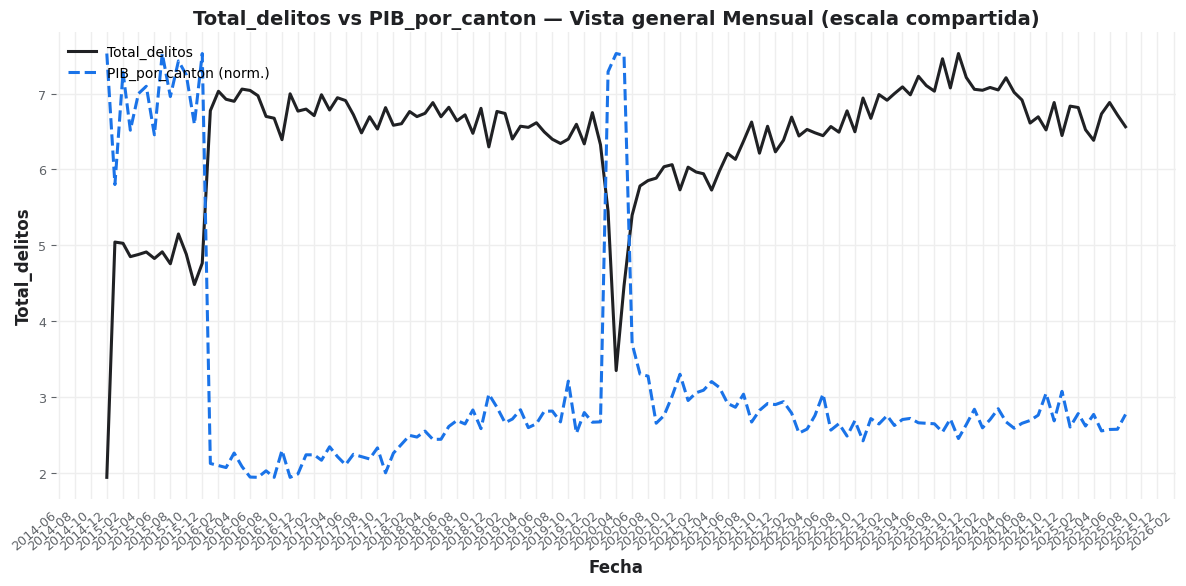

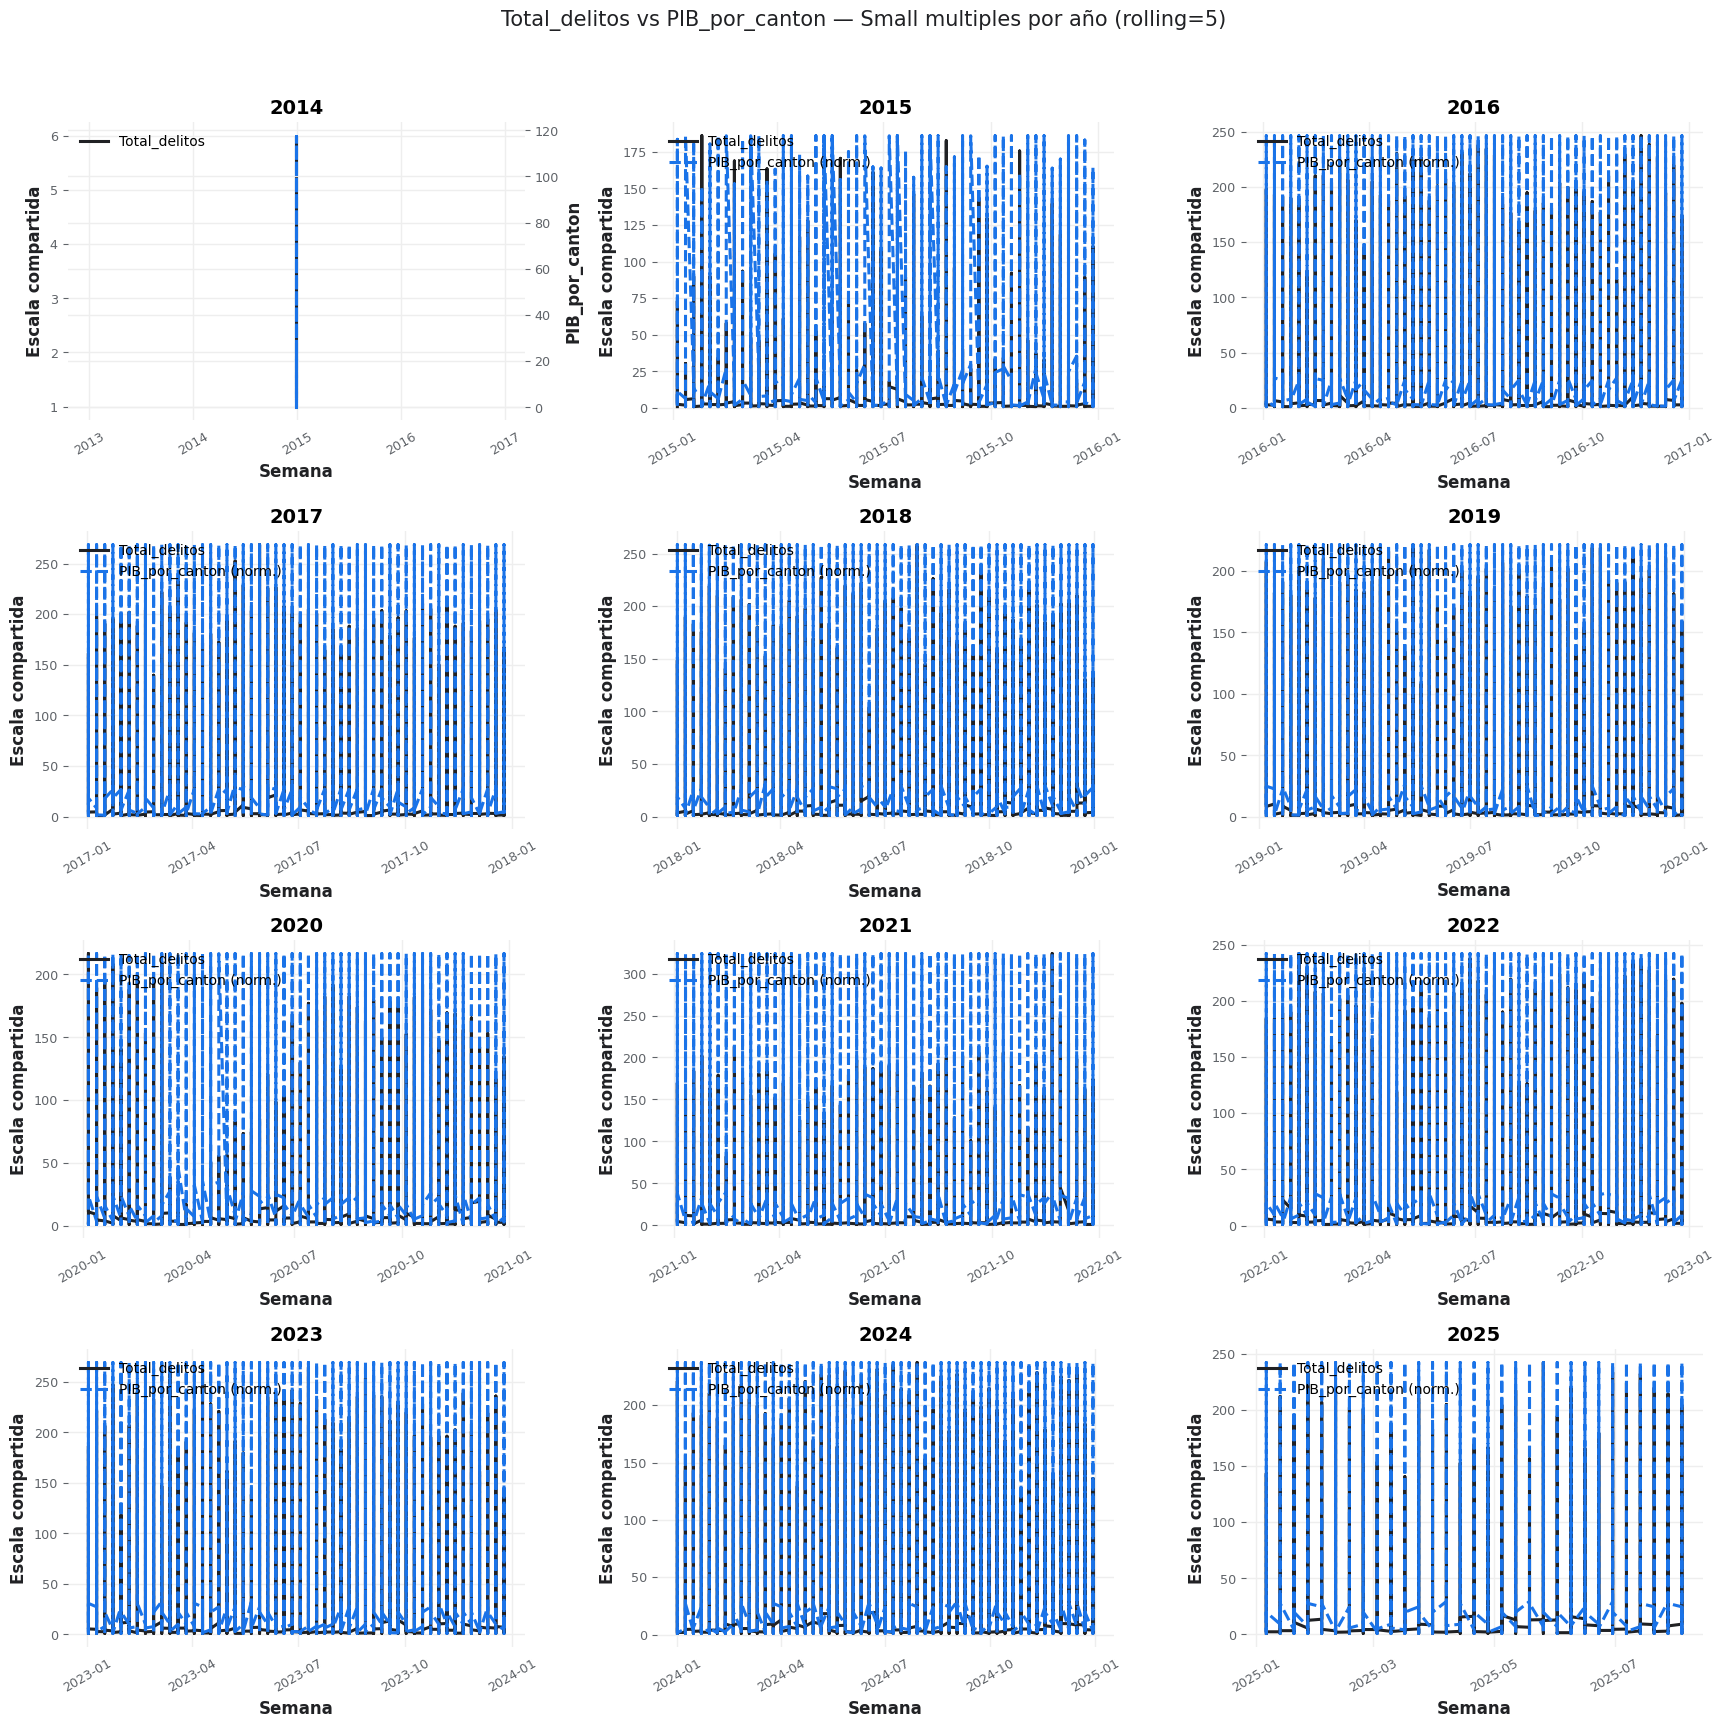

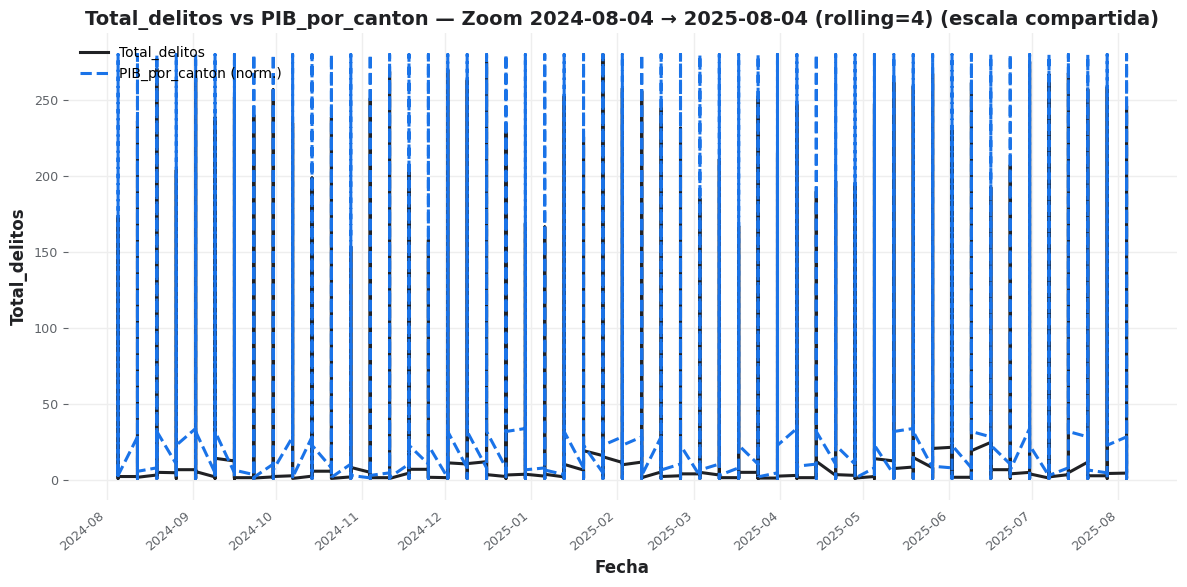

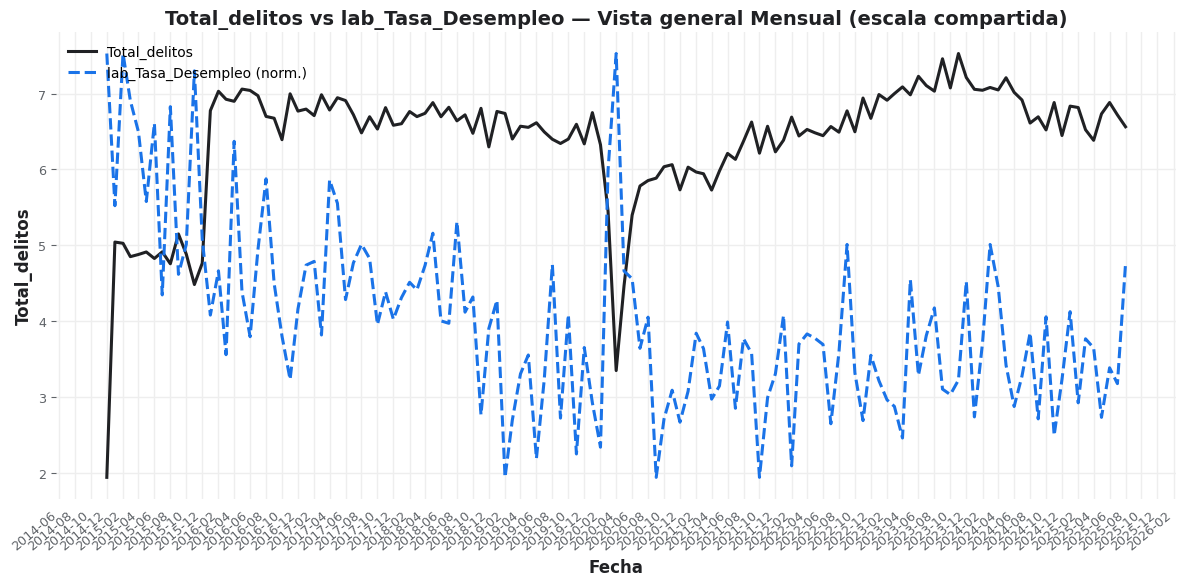

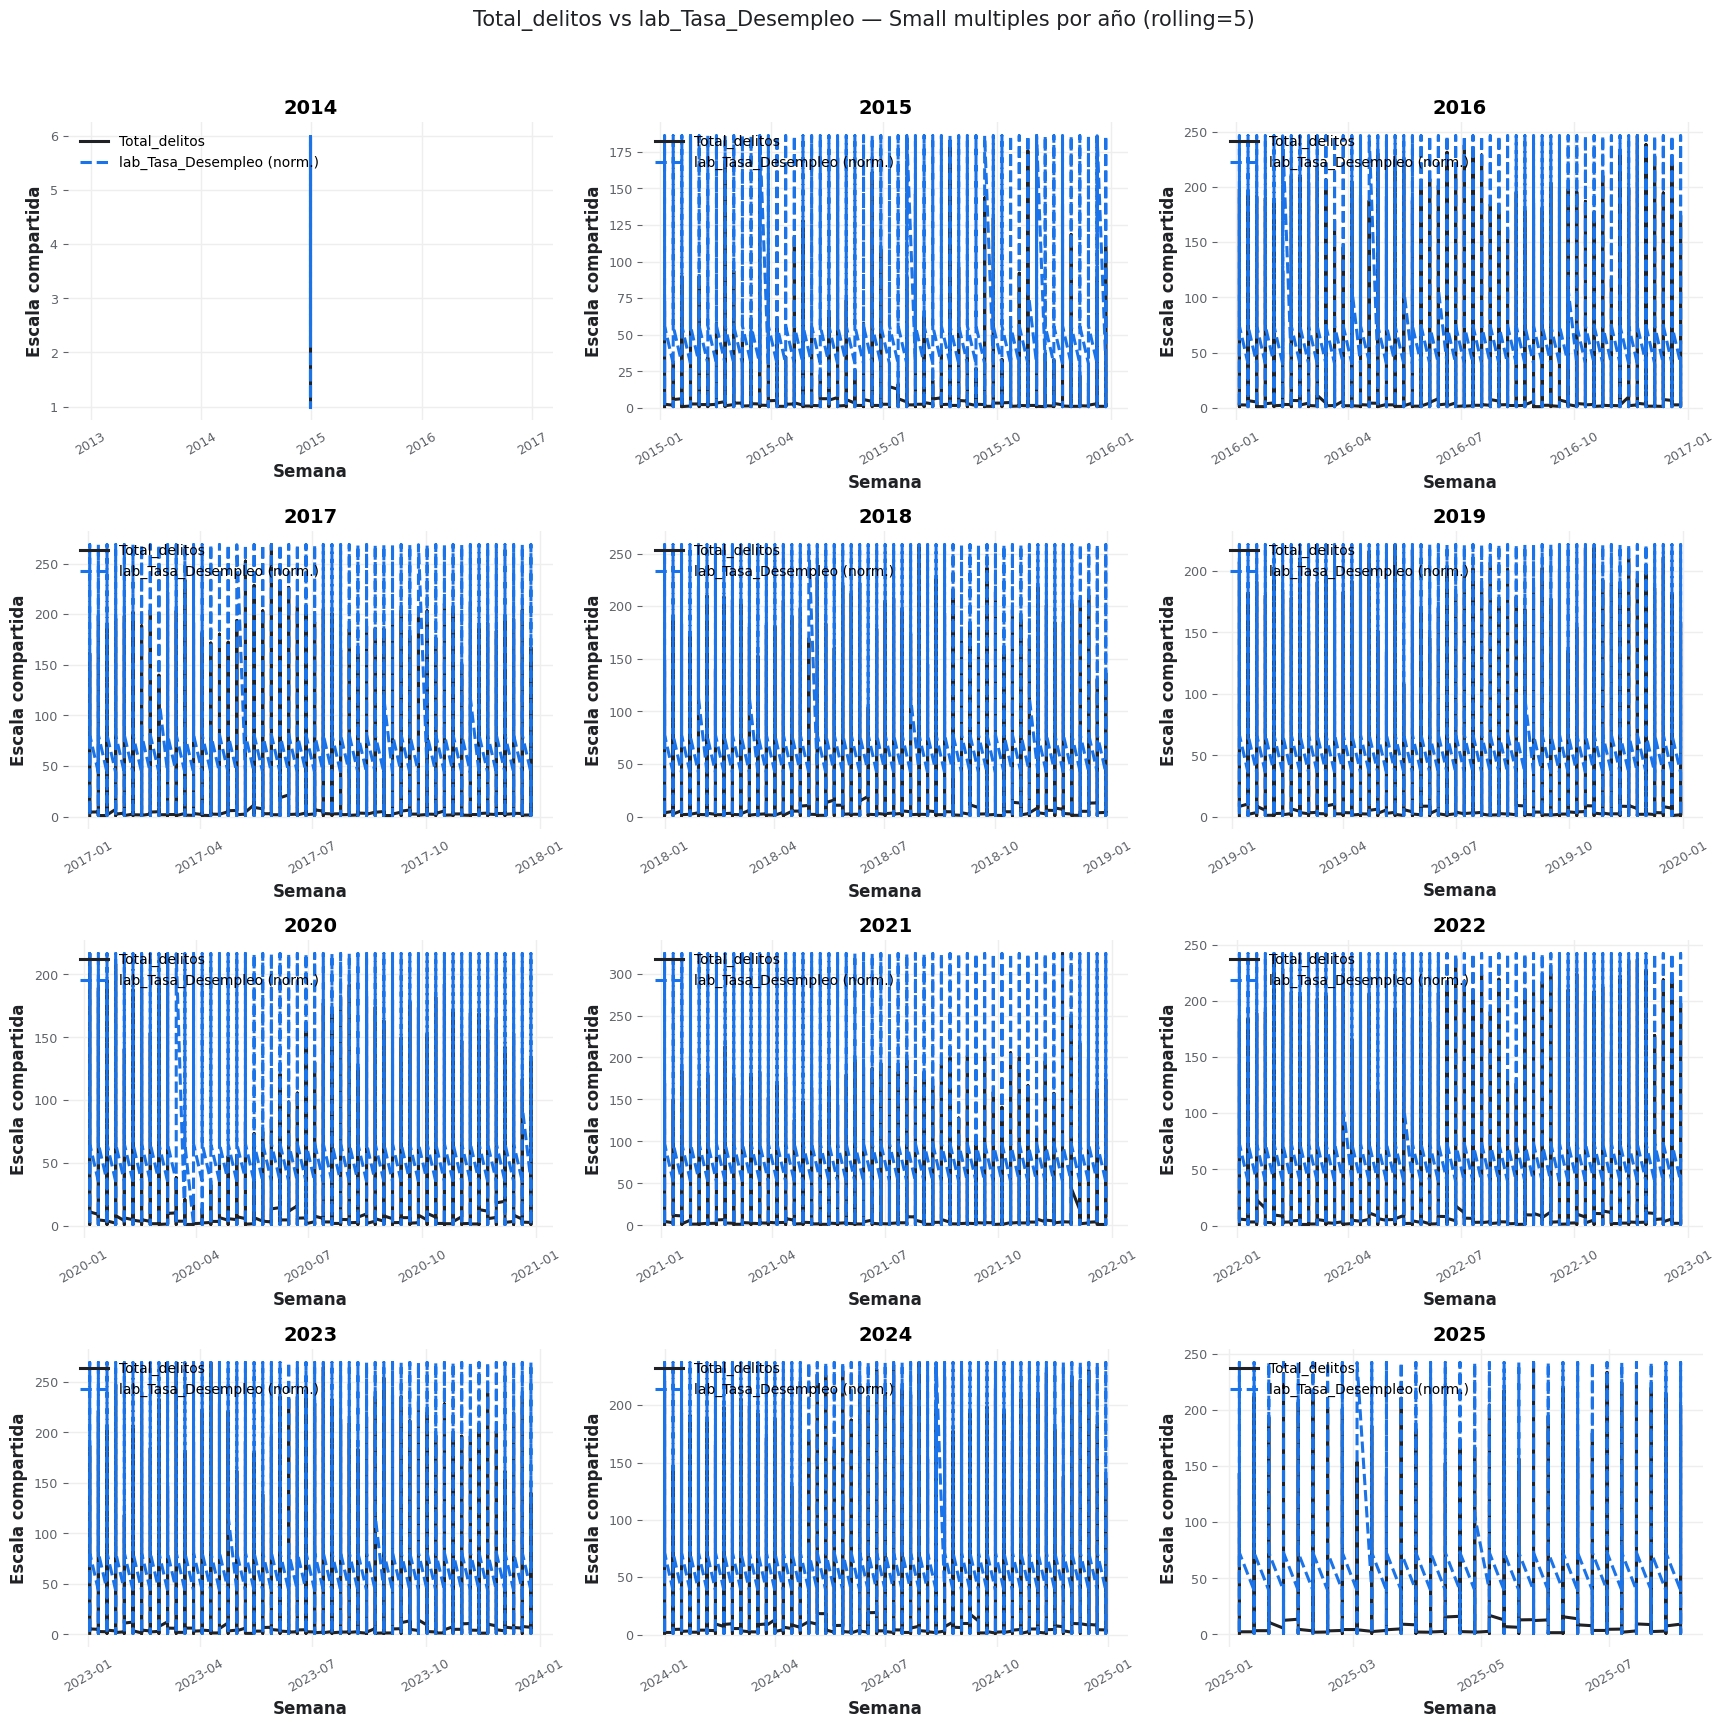

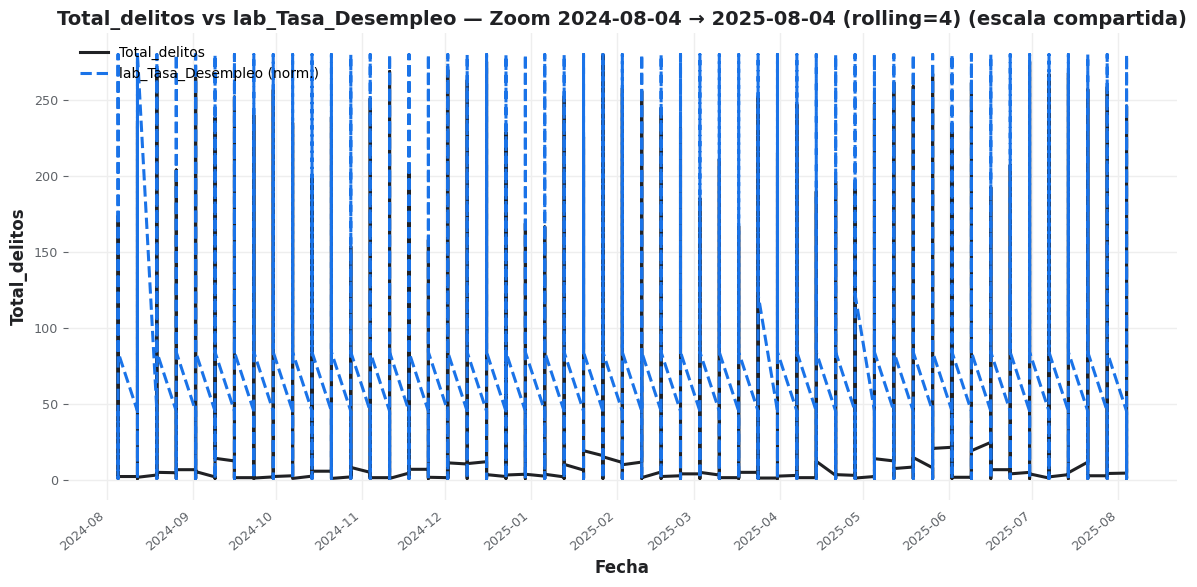

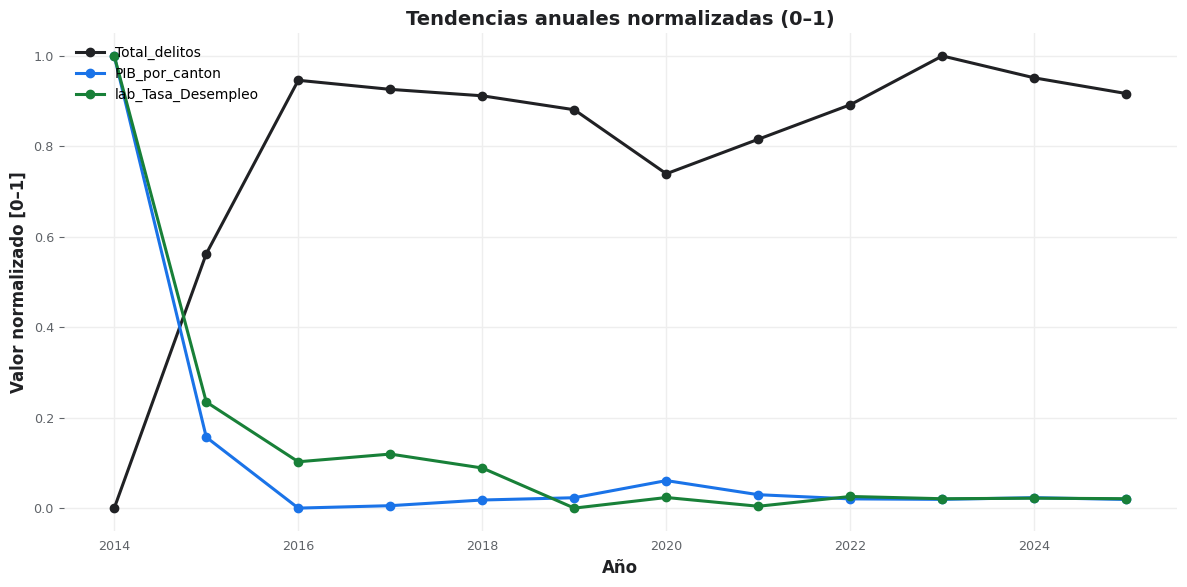

C:\Users\uide\AppData\Local\Temp\ipykernel_11540\2252498238.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = ax.legend(loc=legend_loc)


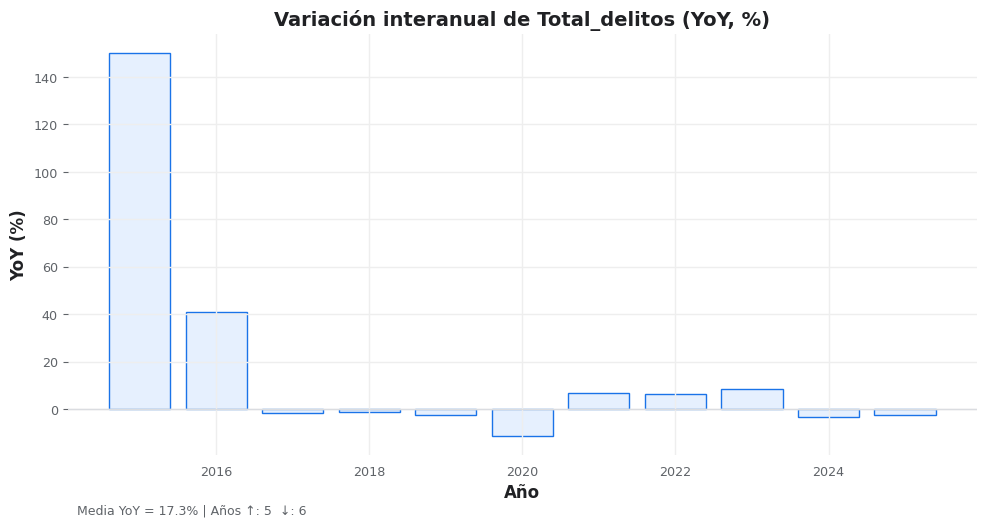

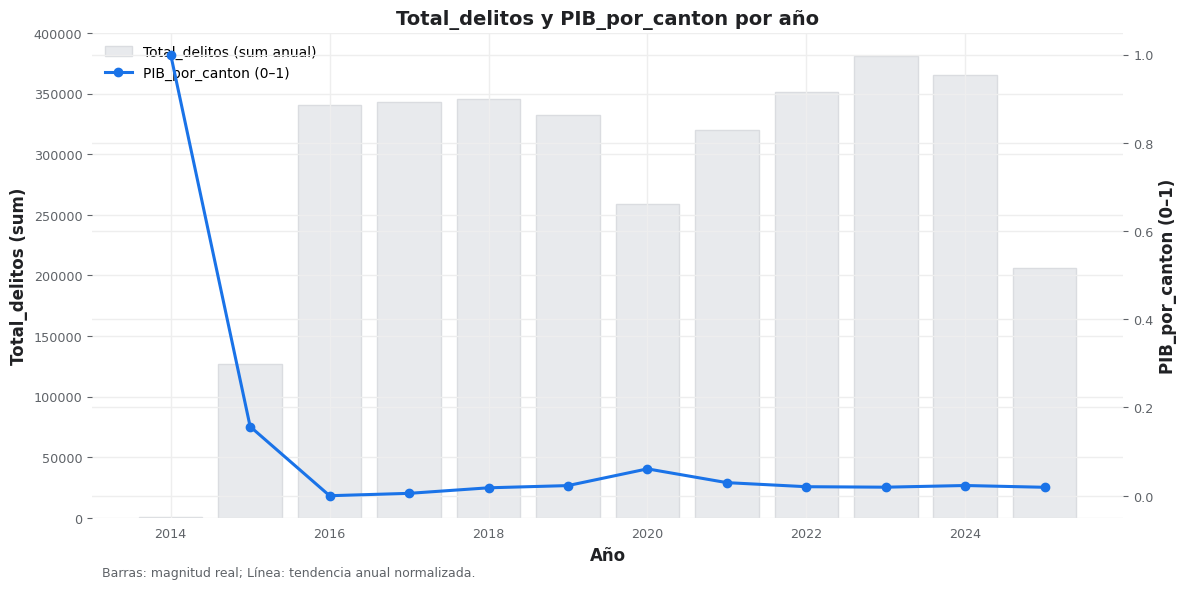

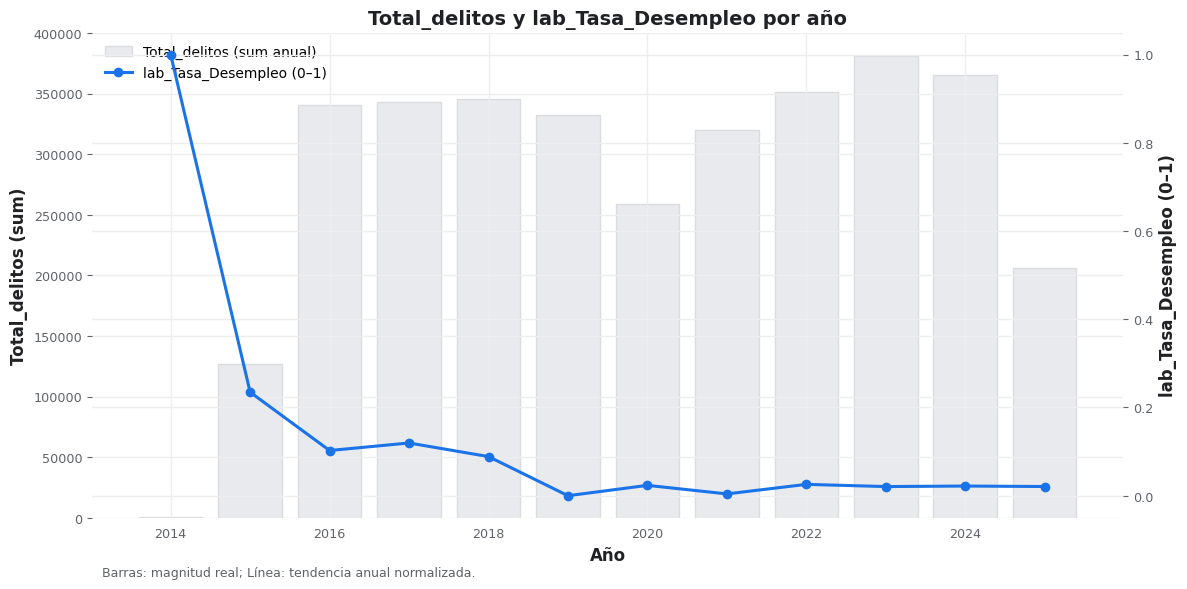

In [4]:
# ==========================================
# PASO 3) Visualización: target vs exógenas + contexto anual
# ==========================================
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter, MonthLocator, AutoDateLocator
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# --- Tema visual "Google‑like" ---
G_COLORS = {
    "ink":     "#202124",
    "muted":   "#5f6368",
    "blue":    "#1a73e8",
    "green":   "#188038",
    "purple":  "#9334e6",
    "teal":    "#12b5cb",
    "red":     "#d93025",
    "gray":    "#dadce0",
}
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": G_COLORS["gray"],
    "axes.labelcolor": G_COLORS["ink"],
    "axes.grid": True,
    "grid.color": "#eee",
    "grid.linestyle": "-",
    "grid.linewidth": 1.0,
    "xtick.color": G_COLORS["muted"],
    "ytick.color": G_COLORS["muted"],
    "axes.titleweight": 600,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "lines.linewidth": 2.2,
    "savefig.bbox": "tight",
})

def _format_ax(ax, title=None, xlabel=None, ylabel=None, legend_loc="upper left"):
    if title:  ax.set_title(title, color=G_COLORS["ink"])
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, which="both", axis="both")
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color(G_COLORS["gray"])
    ax.spines["bottom"].set_color(G_COLORS["gray"])
    leg = ax.legend(loc=legend_loc)
    if leg: leg.get_frame().set_alpha(0.0)

# ---------- Helpers de escala robusta ----------
def _robust_min_max(x, q_low=0.02, q_high=0.98):
    lo, hi = np.nanquantile(x, q_low), np.nanquantile(x, q_high)
    if np.isclose(hi, lo):
        return np.zeros_like(x)
    x_clip = np.clip(x, lo, hi)
    return (x_clip - lo) / (hi - lo)

def _should_use_twin_axis(target_vals, exog_vals, threshold=4.0):
    t_span = np.nanquantile(target_vals, 0.90) - np.nanquantile(target_vals, 0.10)
    e_span = np.nanquantile(exog_vals,   0.90) - np.nanquantile(exog_vals,   0.10)
    if t_span <= 0: 
        return True
    ratio = (e_span / t_span) if t_span>0 else np.inf
    return ratio >= threshold

# ---------- Gráficas target vs exógena ----------
def plot_target_vs_exog_overview(df_full, time_dt_col, target_col, exog_col, max_points=160):
    d = df_full[[time_dt_col, target_col, exog_col]].dropna().sort_values(time_dt_col)
    d = d.set_index(time_dt_col)
    if len(d) > max_points:
        d = d.resample("MS").mean()
        label_freq = "Mensual"
    else:
        d = d.resample("W-MON").mean()
        label_freq = "Semanal (agregada)"

    t = d[target_col].values
    e = d[exog_col].values
    use_twin = _should_use_twin_axis(t, e, threshold=4.0)

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(d.index, t, color=G_COLORS["ink"], label=target_col)

    if use_twin:
        ax2 = ax1.twinx()
        ax2.plot(d.index, e, color=G_COLORS["blue"], linestyle="--", label=exog_col)
        ax2.set_ylabel(exog_col + " (escala propia)")
        h1,l1 = ax1.get_legend_handles_labels()
        h2,l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper left")
        extra = " (eje secundario)"
    else:
        e_norm = _robust_min_max(e)
        e_rescaled = e_norm * (t.max() - t.min() + 1e-9) + t.min()
        ax1.plot(d.index, e_rescaled, color=G_COLORS["blue"], linestyle="--", label=f"{exog_col} (norm.)")
        ax1.legend(loc="upper left")
        extra = " (escala compartida)"

    ax1.xaxis.set_major_locator(MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax1.get_xticklabels(), rotation=40, ha="right")
    _format_ax(ax1, title=f"{target_col} vs {exog_col} — Vista general {label_freq}{extra}",
               xlabel="Fecha", ylabel=target_col)
    plt.tight_layout(); plt.show()

def plot_target_vs_exog_small_multiples(df_full, time_dt_col, target_col, exog_col, smooth_window=5):
    d = df_full[[time_dt_col, target_col, exog_col]].dropna().copy()
    d["anio"] = d[time_dt_col].dt.year
    years = sorted(d["anio"].unique())
    if not years:
        print(f"[AVISO] No hay datos para {target_col} vs {exog_col}"); return

    n = len(years); cols = 3; rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5.8*cols, 4.4*rows))
    axes = np.atleast_2d(axes)

    for i, year in enumerate(years):
        ax = axes[i//cols, i%cols]
        s = d[d["anio"] == year].sort_values(time_dt_col)
        y = s[target_col].rolling(smooth_window, min_periods=1).mean().values
        ex = s[exog_col].values
        use_twin = _should_use_twin_axis(y, ex, threshold=4.0)
        ax.plot(s[time_dt_col], y, color=G_COLORS["ink"], label=target_col)

        if use_twin:
            ax2 = ax.twinx()
            ax2.plot(s[time_dt_col], ex, color=G_COLORS["blue"], linestyle="--", label=exog_col)
            ax2.set_ylabel(exog_col)
            h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
            ax.legend(h1+h2, l1+l2, fontsize=8, loc="upper left")
        else:
            ex_norm = _robust_min_max(ex)
            ex_rescaled = ex_norm * (y.max() - y.min() + 1e-9) + y.min()
            ax.plot(s[time_dt_col], ex_rescaled, color=G_COLORS["blue"], linestyle="--", label=f"{exog_col} (norm.)")
            ax.legend(fontsize=8, loc="upper left")

        ax.set_title(str(year)); ax.tick_params(axis='x', rotation=30)
        ax.xaxis.set_major_locator(AutoDateLocator(minticks=3, maxticks=6))
        _format_ax(ax, xlabel="Semana", ylabel="Escala compartida", legend_loc="upper left")

    # limpia ejes vacíos
    total = rows*cols
    for j in range(len(years), total):
        fig.delaxes(axes[j//cols, j%cols])

    fig.suptitle(f"{target_col} vs {exog_col} — Small multiples por año (rolling={smooth_window})",
                 fontsize=15, color=G_COLORS["ink"])
    fig.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

def plot_target_vs_exog_zoom(df_full, time_dt_col, target_col, exog_col, start=None, end=None, smooth_window=4):
    d = df_full[[time_dt_col, target_col, exog_col]].dropna().copy().sort_values(time_dt_col)
    if start is None or end is None:
        max_date = d[time_dt_col].max()
        start = (max_date - pd.DateOffset(years=1)).normalize()
        end = max_date
    m = (d[time_dt_col] >= pd.to_datetime(start)) & (d[time_dt_col] <= pd.to_datetime(end))
    z = d.loc[m]
    if z.empty:
        print(f"[AVISO] Rango sin datos: {start}→{end}"); return

    y = z[target_col].rolling(smooth_window, min_periods=1).mean().values
    ex = z[exog_col].values
    use_twin = _should_use_twin_axis(y, ex, threshold=4.0)

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(z[time_dt_col], y, color=G_COLORS["ink"], label=target_col)

    if use_twin:
        ax2 = ax.twinx()
        ax2.plot(z[time_dt_col], ex, color=G_COLORS["blue"], linestyle="--", label=exog_col)
        ax2.set_ylabel(exog_col)
        h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
        ax.legend(h1+h2, l1+l2, loc="upper left")
        extra = " (eje secundario)"
    else:
        ex_norm = _robust_min_max(ex)
        ex_rescaled = ex_norm * (y.max() - y.min() + 1e-9) + y.min()
        ax.plot(z[time_dt_col], ex_rescaled, color=G_COLORS["blue"], linestyle="--", label=f"{exog_col} (norm.)")
        ax.legend(loc="upper left")
        extra = " (escala compartida)"

    ax.xaxis.set_major_locator(MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=40, ha="right")
    _format_ax(ax, title=f"{target_col} vs {exog_col} — Zoom {pd.to_datetime(start).date()} → {pd.to_datetime(end).date()} (rolling={smooth_window}){extra}",
               xlabel="Fecha", ylabel=target_col)
    plt.tight_layout(); plt.show()

# ---------- Contexto anual ----------
def plot_yearly_normalized(df_full, time_dt_col, cols, title="Tendencias anuales normalizadas (0–1)"):
    tmp = df_full[[time_dt_col] + cols].dropna().copy()
    tmp["anio"] = tmp[time_dt_col].dt.year
    yearly = tmp.groupby("anio")[cols].mean()
    scaler = MinMaxScaler()
    ys = pd.DataFrame(scaler.fit_transform(yearly), columns=cols, index=yearly.index)
    fig, ax = plt.subplots(figsize=(12, 6))
    palette = [G_COLORS["ink"], G_COLORS["blue"], G_COLORS["green"], G_COLORS["purple"], G_COLORS["teal"]]
    for i, c in enumerate(cols):
        ax.plot(ys.index, ys[c], marker="o", label=c, color=palette[i % len(palette)])
    _format_ax(ax, title=title, xlabel="Año", ylabel="Valor normalizado [0–1]")
    plt.tight_layout(); plt.show()

def plot_bar_line_dualaxis(df_full, time_dt_col, target_col, exog_col, agg="sum"):
    tmp = df_full[[time_dt_col, target_col, exog_col]].dropna().copy()
    tmp["anio"] = tmp[time_dt_col].dt.year
    annual_target = getattr(tmp.groupby("anio")[[target_col]], {"sum":"sum","mean":"mean"}[agg])()
    annual_ex = tmp.groupby("anio")[[exog_col]].mean()
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.bar(annual_target.index, annual_target[target_col],
            color="#e8eaed", edgecolor=G_COLORS["gray"], label=f"{target_col} ({agg} anual)")
    ax1.set_ylabel(f"{target_col} ({agg})"); ax1.set_xlabel("Año"); ax1.grid(True, axis="y")
    ax2 = ax1.twinx()
    ex = annual_ex[exog_col]
    ex_norm = (ex - ex.min()) / (ex.max() - ex.min() + 1e-9)
    ax2.plot(annual_ex.index, ex_norm, marker="o", color=G_COLORS["blue"], label=f"{exog_col} (0–1)")
    ax2.set_ylabel(f"{exog_col} (0–1)")
    _format_ax(ax1, title=f"{target_col} y {exog_col} por año")
    h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper left")
    ax1.text(0.01, -0.12, "Barras: magnitud real; Línea: tendencia anual normalizada.",
             transform=ax1.transAxes, fontsize=9, color=G_COLORS["muted"])
    fig.tight_layout(); plt.show()

def plot_yoy(df_full, time_dt_col, target_col):
    tmp = df_full[[time_dt_col, target_col]].dropna().copy()
    tmp["anio"] = tmp[time_dt_col].dt.year
    annual_mean = tmp.groupby("anio")[target_col].mean()
    yoy = annual_mean.pct_change() * 100
    fig, ax = plt.subplots(figsize=(10, 5.4))
    ax.bar(yoy.index, yoy.values, color="#e6f0fe", edgecolor=G_COLORS["blue"])
    ax.axhline(0, color=G_COLORS["gray"], linewidth=1)
    _format_ax(ax, title=f"Variación interanual de {target_col} (YoY, %)", xlabel="Año", ylabel="YoY (%)")
    txt = f"Media YoY = {np.nanmean(yoy.values):.1f}% | Años ↑: {(yoy>0).sum()}  ↓: {(yoy<0).sum()}"
    ax.text(0.01, -0.14, txt, transform=ax.transAxes, fontsize=9, color=G_COLORS["muted"])
    plt.tight_layout(); plt.show()

# ---------- Llamadas de dibujo ----------
# Nota: aquí usamos df (original con _time_dt) para vistas generales,
# y df_nat / df_nat_all para agregados semanales ya consolidados.

try:
    if len(use_exogs) > 0:
        for ex in use_exogs:
            plot_target_vs_exog_overview(df, "_time_dt", TARGET_VAR, ex, max_points=160)
            plot_target_vs_exog_small_multiples(df, "_time_dt", TARGET_VAR, ex, smooth_window=5)
            plot_target_vs_exog_zoom(df, "_time_dt", TARGET_VAR, ex, start=None, end=None, smooth_window=4)
    else:
        print("[INFO] No hay exógenas seleccionadas; se salta la comparación visual.")
except Exception as e:
    print("[WARN] Falló alguna visualización target vs exógenas:", e)

# Contexto anual
cols_year = [TARGET_VAR] + (use_exogs if len(use_exogs)>0 else [])
try:
    plot_yearly_normalized(df, "_time_dt", cols_year, title="Tendencias anuales normalizadas (0–1)")
    plot_yoy(df, "_time_dt", TARGET_VAR)
    if len(use_exogs)>0:
        for ex in use_exogs:
            plot_bar_line_dualaxis(df, "_time_dt", TARGET_VAR, ex, agg="sum")
except Exception as e:
    print("[WARN] Falló alguna visualización anual:", e)


In [3]:
# Repara entorno numérico y verifica versiones clave
import sys, subprocess, importlib
def _pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs
    subprocess.run(cmd, check=False)
    importlib.invalidate_caches()

# Forzamos una versión de numpy estable para Py310 + torch 2.0.x + pl 1.9.x
_pip_install(["numpy==1.24.4"])

# (Opcional, si tuviste conflictos) descomenta para forzar también scipy/pandas estables:
# _pip_install(["scipy==1.10.1", "pandas==2.0.3"])

# Mostrar versiones
import numpy as np, torch
from importlib.metadata import version
print("numpy:", np.__version__)
print("torch:", torch.__version__)
try:
    print("pytorch_lightning:", version("pytorch-lightning"))
except Exception:
    try:
        import lightning as L
        print("lightning:", L.__version__)
    except Exception as e:
        print("lightning/pl no detectado:", e)
try:
    import darts
    print("darts:", darts.__version__)
except Exception as e:
    print("darts import error:", e)


numpy: 1.24.4
torch: 1.13.1+cpu
pytorch_lightning: 1.9.5
darts: 0.37.1


In [4]:
# ==========================================
# PASO 4 — Modelado completo (CPU‑friendly, ARIMA fix)
# ES, ARIMA(+exógenas), XGBoost (walk-forward), TFT (+exógenas optimizado CPU)
# Requisitos previos: PASO 2 (df_nat, use_exogs, TARGET_VAR, FREQ)
# ==========================================
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, TFTModel
from darts.dataprocessing.transformers import Scaler

# ------- 0) Chequeos y reconstrucción de splits -------
for var in ("df_nat", "TARGET_VAR", "FREQ"):
    assert var in globals(), f"{var} no definido. Ejecuta PASO 2."

# Construir ts_all y split si faltan
if "ts_all" not in globals() or "split_idx" not in globals():
    ts_all = TimeSeries.from_times_and_values(
        df_nat.index, df_nat[[TARGET_VAR]].values, freq=FREQ
    )
    split_idx = int(len(ts_all) * 0.90)
    train, val = ts_all.split_after(split_idx)
else:
    train, val = ts_all.split_after(split_idx)

use_exogs = globals().get("use_exogs", [])

# ==========================================================
# 1) Baseline: Suavizamiento Exponencial
# ==========================================================
es_model = ExponentialSmoothing()
es_model.fit(train)
es_pred = es_model.predict(n=len(val))

# ==========================================================
# 2) ARIMA con/sin exógenas (future_covariates)  — (FIX sin walrus)
# ==========================================================
def _build_future_covariates(df_like: pd.DataFrame, exog_cols: list, freq):
    if not exog_cols:
        return None
    cols = [c for c in exog_cols if c in df_like.columns]
    if not cols:
        return None
    sub = df_like[cols].dropna()
    if sub.empty:
        return None
    if not isinstance(sub.index, pd.DatetimeIndex):
        raise TypeError("Las exógenas necesitan DatetimeIndex en el índice.")
    return TimeSeries.from_times_and_values(sub.index, sub.values, freq=freq)

arima_pred = None
try:
    future_covs = _build_future_covariates(df_nat, use_exogs, FREQ)
    if future_covs is not None:
        ftrain, _ = future_covs.split_after(split_idx)
        arima_model = ARIMA(order=(1,1,1))
        arima_model.fit(train, future_covariates=ftrain)
        arima_pred = arima_model.predict(n=len(val), future_covariates=future_covs)
        print("[OK] ARIMA con exógenas entrenado.")
    else:
        arima_model = ARIMA(order=(1,1,1))
        arima_model.fit(train)
        arima_pred = arima_model.predict(n=len(val))
        print("[OK] ARIMA univariante entrenado (sin exógenas disponibles).")
except TypeError as e:
    # Algunas versiones cambian firmas; usar auto-ARIMA como fallback
    print("[WARN] ARIMA(1,1,1) falló; probando auto-ARIMA. Detalle:", e)
    try:
        arima_model = ARIMA()  # auto-ARIMA
        if future_covs is not None:
            ftrain, _ = future_covs.split_after(split_idx)
            arima_model.fit(train, future_covariates=ftrain)
            arima_pred = arima_model.predict(n=len(val), future_covariates=future_covs)
            print("[OK] auto-ARIMA con exógenas entrenado.")
        else:
            arima_model.fit(train)
            arima_pred = arima_model.predict(n=len(val))
            print("[OK] auto-ARIMA univariante entrenado.")
    except Exception as e2:
        print("[ERROR] ARIMA también falló en modo auto:", e2)
        arima_pred = None
except Exception as e:
    print("[ERROR] ARIMA falló:", e)
    arima_pred = None

# ==========================================================
# 3) XGBoost (walk‑forward) con exógenas (lags y rollings)
# ==========================================================
LAGS = [1,2,3,4,8,12]
ROLLS = [4,8,12]
EXOG_LAGS = [1,2,4]

def make_supervised_matrix(df_nat_local, target_col, exogs, lags, rolls, exog_lags):
    dfm = df_nat_local[[target_col] + exogs].copy()
    # lags del target
    for l in lags:
        dfm[f"{target_col}_lag{l}"] = dfm[target_col].shift(l)
    # medias móviles del target
    for w in rolls:
        dfm[f"{target_col}_roll{w}_mean"] = dfm[target_col].rolling(w).mean()
    # lags de exógenas
    for ex in exogs:
        for l in exog_lags:
            dfm[f"{ex}_lag{l}"] = dfm[ex].shift(l)
    dfm = dfm.dropna().copy()
    X = dfm.drop(columns=[target_col])
    y = dfm[target_col]
    return X, y, dfm.index

def xgb_walk_forward_predict(df_nat_local, target_col, exogs, lags, rolls, exog_lags,
                             val_start_idx, n_val, random_state=42):
    if not isinstance(df_nat_local.index, pd.DatetimeIndex):
        raise TypeError("df_nat_local debe tener DatetimeIndex en el índice.")
    df_nat_local = df_nat_local.sort_index()

    X_full, y_full, idx_full = make_supervised_matrix(
        df_nat_local, target_col, exogs, lags, rolls, exog_lags
    )

    # localizar inicio de validación dentro de la matriz supervisada
    idx_full_i8 = pd.DatetimeIndex(idx_full).asi8
    val_start_i8 = pd.Timestamp(val_start_idx).value
    start_pos = np.searchsorted(idx_full_i8, val_start_i8, side="left")
    if start_pos <= 0:
        raise ValueError("El inicio de validación cae antes de tener suficientes lags/rollings.")

    X_tr, y_tr = X_full.iloc[:start_pos], y_full.iloc[:start_pos]

    model = XGBRegressor(
        n_estimators=600, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0, reg_lambda=1.0,
        random_state=random_state, n_jobs=-1
    )
    model.fit(X_tr, y_tr)

    # simulación iterativa: usa última exógena observada como proxy futura
    df_iter = df_nat_local.copy()
    preds = []
    for _ in range(n_val):
        X_step, _, _ = make_supervised_matrix(df_iter, target_col, exogs, lags, rolls, exog_lags)
        y_hat = float(model.predict(X_step.iloc[[-1]]))
        preds.append(y_hat)
        next_time = df_iter.index.max() + pd.tseries.frequencies.to_offset(FREQ)
        new_row = {target_col: y_hat}
        for ex in exogs:
            new_row[ex] = df_iter[ex].iloc[-1]
        df_iter.loc[next_time] = new_row

    val_index = pd.date_range(start=val_start_idx, periods=n_val, freq=FREQ)
    return TimeSeries.from_times_and_values(val_index, np.array(preds).reshape(-1,1), freq=FREQ)

val_start = val.start_time()
xgb_pred = xgb_walk_forward_predict(
    df_nat, TARGET_VAR, use_exogs,
    LAGS, ROLLS, EXOG_LAGS,
    val_start_idx=val_start, n_val=len(val), random_state=42
)
print("[OK] XGBoost walk‑forward entrenado.")

# ==========================================================
# 4) TFT (+exógenas) — versión optimizada para CPU
# ==========================================================
# Construcción de covariables pasadas con TODAS las exógenas seleccionadas
series_exogs_all = None
if len(use_exogs) > 0:
    try:
        ex_cols = [c for c in use_exogs if c in df_nat.columns]
        df_ex_all = df_nat[ex_cols].dropna()
        common_idx = df_nat.index.intersection(df_ex_all.index)
        df_ex_all = df_ex_all.reindex(common_idx)
        ts_ex_all = TimeSeries.from_times_and_values(df_ex_all.index, df_ex_all.values, freq=FREQ)
        series_exogs_all = ts_ex_all.slice_intersect(ts_all)  # asegurar alineación
    except Exception as e:
        print("[WARN] No se pudo construir covariables para TFT:", e)
        series_exogs_all = None
else:
    print("[INFO] TFT sin exógenas (no hay seleccionadas).")

# Splits idénticos a y
train_y, val_y = ts_all.split_after(split_idx)
train_x = val_x = full_x = None
if series_exogs_all is not None:
    train_x, val_x = series_exogs_all.split_after(split_idx)
    full_x = series_exogs_all

# Escalado
scaler_y_tft = Scaler()
y_train_t = scaler_y_tft.fit_transform(train_y)
y_val_t   = scaler_y_tft.transform(val_y)

x_train_t = x_val_t = x_full_t = None
if train_x is not None:
    scaler_x_tft = Scaler()
    x_train_t = scaler_x_tft.fit_transform(train_x)
    x_val_t   = scaler_x_tft.transform(val_x)
    x_full_t  = scaler_x_tft.transform(full_x)

# Grid optimizado para CPU (duración razonable y chance de aprender)
tft_cfgs_cpu = [
    {"input_chunk_length": 16, "output_chunk_length": 4, "hidden_size": 48,  "dropout": 0.20, "lstm_layers": 1, "epochs": 50, "batch_size": 32},
    {"input_chunk_length": 24, "output_chunk_length": 4, "hidden_size": 64,  "dropout": 0.25, "lstm_layers": 1, "epochs": 75, "batch_size": 32},
    {"input_chunk_length": 36, "output_chunk_length": 4, "hidden_size": 96,  "dropout": 0.30, "lstm_layers": 2, "epochs": 100, "batch_size": 32},
    {"input_chunk_length": 52, "output_chunk_length": 4, "hidden_size": 96,  "dropout": 0.30, "lstm_layers": 2, "epochs": 150, "batch_size": 24},
]

encoders = {
    "datetime_attribute": {"future": ["month", "weekofyear", "dayofweek"]},
    "cyclic": {"future": ["month", "weekofyear"]},
    "position": {"future": "relative"},
}

best_pred  = None
best_cfg   = None
best_proxy = np.inf

for cfg in tft_cfgs_cpu:
    try:
        mdl = TFTModel(
            input_chunk_length=cfg["input_chunk_length"],
            output_chunk_length=cfg["output_chunk_length"],
            hidden_size=cfg["hidden_size"],
            lstm_layers=cfg["lstm_layers"],
            num_attention_heads=2,   # mantener bajo en CPU
            dropout=cfg["dropout"],
            batch_size=cfg["batch_size"],
            add_relative_index=True,
            add_encoders=encoders,
            force_reset=True,
            random_state=42,
            show_warnings=False,
            pl_trainer_kwargs={
                "max_epochs": cfg["epochs"],
                "accelerator": "cpu",
                "devices": 1,
                "enable_progress_bar": False,
                "gradient_clip_val": 0.5,
                "enable_model_summary": False,
            },
        )

        mdl.fit(
            y_train_t,
            past_covariates=x_train_t,  # puede ser None si no hay exógenas
            val_series=y_val_t,
            val_past_covariates=x_val_t,
            verbose=False
        )

        # Predice todo el tramo de validación
        yhat_t = mdl.predict(n=len(val_y), past_covariates=x_full_t)
        yhat   = scaler_y_tft.inverse_transform(yhat_t)

        # Proxy simple para escoger mejor config (métricas reales en PASO 5)
        proxy = float(np.var(val_y.values() - yhat.values()))
        if proxy < best_proxy:
            best_proxy = proxy
            best_pred  = yhat
            best_cfg   = cfg

    except Exception as e:
        print(f"[WARN] TFT CPU falló con cfg={cfg}: {e}")

if best_pred is not None:
    print(f"[OK] TFT (CPU) entrenado. Mejor cfg: {best_cfg} | proxy_var={best_proxy:.2f}")
else:
    print("[INFO] TFT no produjo predicción válida; se omitirá si sigue así en el PASO 5.")

# ==========================================================
# 5) Salidas para PASO 5
# ==========================================================
if "preds_dict" not in globals():
    preds_dict = {}
preds_dict["ExpSmooth"] = es_pred
preds_dict["ARIMA"]     = arima_pred
preds_dict["XGBoost"]   = xgb_pred
preds_dict["TFT"]       = best_pred  # puede ser None si todas las cfg fallaron

print("[OK] Modelos entrenados. 'preds_dict' listo (ES, ARIMA, XGBoost, TFT).")
print(f"[INFO] len(train)={len(train)}, len(val)={len(val)} | rango val: {val.start_time().date()} → {val.end_time().date()}")
if best_cfg:
    print(f"[INFO] Mejor cfg TFT (CPU): {best_cfg}")


[WARN] ARIMA(1,1,1) falló; probando auto-ARIMA. Detalle: ARIMA.__init__() got an unexpected keyword argument 'order'
[OK] auto-ARIMA con exógenas entrenado.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[OK] XGBoost walk‑forward entrenado.


`Trainer.fit` stopped: `max_epochs=50` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=75` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warnin

[WARN] TFT CPU falló con cfg={'input_chunk_length': 52, 'output_chunk_length': 4, 'hidden_size': 96, 'dropout': 0.3, 'lstm_layers': 2, 'epochs': 150, 'batch_size': 24}: The input `series` are too short to extract even a single sample. Expected min length: `56`, received max length: `55`.
[OK] TFT (CPU) entrenado. Mejor cfg: {'input_chunk_length': 36, 'output_chunk_length': 4, 'hidden_size': 96, 'dropout': 0.3, 'lstm_layers': 2, 'epochs': 100, 'batch_size': 32} | proxy_var=732726.83
[OK] Modelos entrenados. 'preds_dict' listo (ES, ARIMA, XGBoost, TFT).
[INFO] len(train)=499, len(val)=55 | rango val: 2024-07-22 → 2025-08-04
[INFO] Mejor cfg TFT (CPU): {'input_chunk_length': 36, 'output_chunk_length': 4, 'hidden_size': 96, 'dropout': 0.3, 'lstm_layers': 2, 'epochs': 100, 'batch_size': 32}



[MÉTRICAS]
ExpSmooth    → RMSE: 1065.10 | MAE: 810.10 | R²: -1.62
ARIMA        → RMSE: 846.72 | MAE: 630.04 | R²: -0.66
XGBoost      → RMSE: 700.72 | MAE: 555.18 | R²: -0.13
TFT          → RMSE: 1087.18 | MAE: 835.60 | R²: -1.73


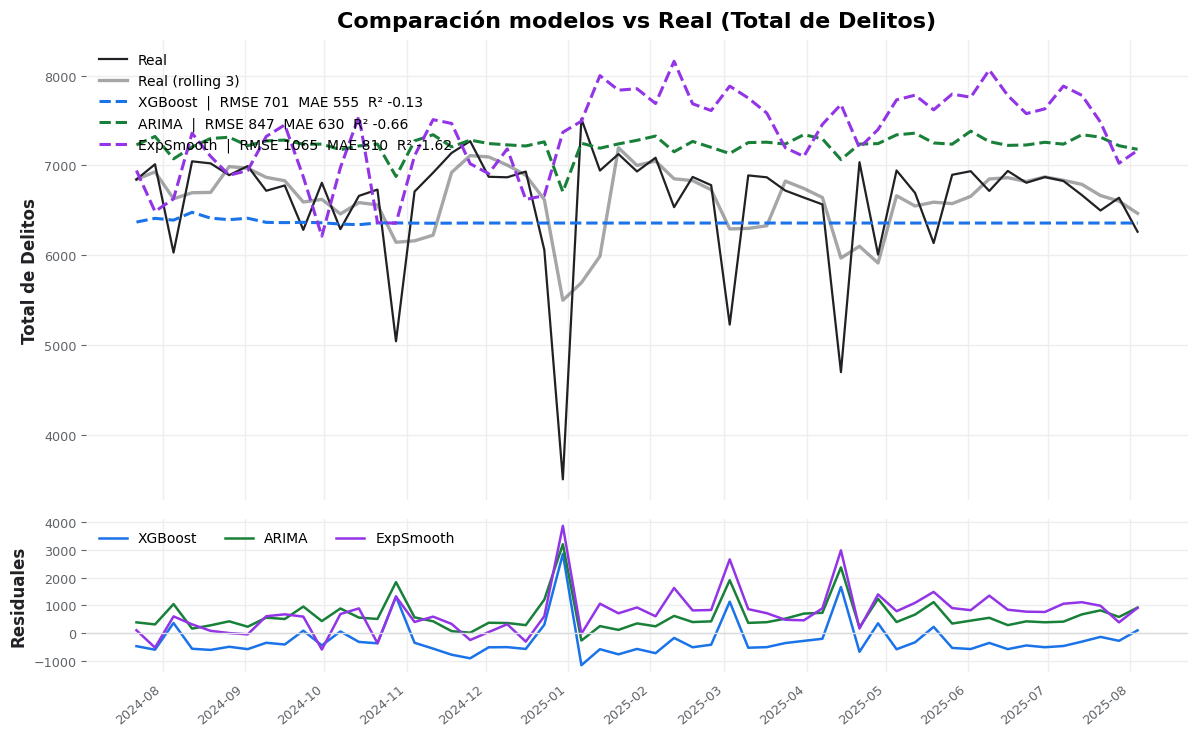


=== CONCLUSIONES ===
XGBoost      -> RMSE=701, MAE=555, R²=-0.13
ARIMA        -> RMSE=847, MAE=630, R²=-0.66
ExpSmooth    -> RMSE=1065, MAE=810, R²=-1.62
TFT          -> RMSE=1087, MAE=836, R²=-1.73
→ Todos los R² son negativos: amplía histórico, revisa frecuencia (W-MON) o calidad de exógenas.
→ Mejor RMSE: XGBoost. Recomendado: backtesting (rolling-origin) para robustez.


In [8]:
# ==========================================
# PASO 5) Métricas robustas + comparación visual + conclusiones
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from darts import TimeSeries

# -------- helpers de formato ----------
G_COLORS = {
    "ink":     "#202124",
    "muted":   "#5f6368",
    "blue":    "#1a73e8",
    "green":   "#188038",
    "purple":  "#9334e6",
    "teal":    "#12b5cb",
    "red":     "#d93025",
    "gray":    "#dadce0",
}
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": G_COLORS["gray"],
    "axes.labelcolor": G_COLORS["ink"],
    "axes.grid": True,
    "grid.color": "#eee",
    "grid.linestyle": "-",
    "grid.linewidth": 1.0,
    "xtick.color": G_COLORS["muted"],
    "ytick.color": G_COLORS["muted"],
    "axes.titleweight": 600,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "lines.linewidth": 2.2,
    "savefig.bbox": "tight",
})

def _format_ax(ax, title=None, xlabel=None, ylabel=None, legend_loc="upper left"):
    if title:  ax.set_title(title, color=G_COLORS["ink"])
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, which="major", axis="both")
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color(G_COLORS["gray"])
    ax.spines["bottom"].set_color(G_COLORS["gray"])
    leg = ax.legend(loc=legend_loc)
    if leg: leg.get_frame().set_alpha(0.0)

# -------- validación y métricas seguras ----------
def _align_and_validate(y_true: TimeSeries, y_pred: TimeSeries, name="model"):
    yt = pd.Series(y_true.values().ravel(), index=y_true.time_index)
    yp = pd.Series(y_pred.values().ravel(), index=y_pred.time_index)

    common_idx = yt.index.intersection(yp.index)
    if len(common_idx) == 0:
        raise ValueError(f"[{name}] No hay intersección temporal entre y_true y y_pred.")

    yt2 = yt.reindex(common_idx)
    yp2 = yp.reindex(common_idx).interpolate().bfill().ffill()

    if np.isnan(yt2.values).any() or np.isnan(yp2.values).any():
        raise ValueError(f"[{name}] NaNs persistentes tras interpolación/ffill.")

    return yt2.values, yp2.values, common_idx

def metrics_safe(name, y_true: TimeSeries, y_pred: TimeSeries):
    try:
        y_t, y_p, _ = _align_and_validate(y_true, y_pred, name=name)
        rmse = float(np.sqrt(mean_squared_error(y_t, y_p)))
        mae  = float(mean_absolute_error(y_t, y_p))
        r2   = float(r2_score(y_t, y_p))
        return rmse, mae, r2
    except Exception as e:
        print(f"[ERROR] Métricas para {name} fallaron: {e}")
        return np.inf, np.inf, -np.inf

# -------- gráfico comparación + residuales ----------
def plot_compare_predictions_readable(val_series: TimeSeries, preds: dict, ylab: str, top_k=3):
    stats = []
    for name, ts in preds.items():
        if ts is None: continue
        rmse, mae, r2 = metrics_safe(name, val_series, ts)
        stats.append((name, rmse, mae, r2))
    if not stats:
        print("[WARN] No hay predicciones válidas para graficar.")
        return
    stats.sort(key=lambda x: x[1])  # ordena por RMSE
    if top_k is not None:
        stats = stats[:top_k]

    palette = [G_COLORS["blue"], G_COLORS["green"], G_COLORS["purple"], G_COLORS["teal"], G_COLORS["red"]]
    fig, (ax, axr) = plt.subplots(2, 1, figsize=(12, 7.5), sharex=True,
                                  gridspec_kw={"height_ratios": [3, 1]})

    # serie real
    real_vals = pd.Series(val_series.values().ravel(), index=val_series.time_index)
    roll_w = 3 if len(val_series) >= 12 else 2
    real_smooth = real_vals.rolling(roll_w, min_periods=1).mean()
    ax.plot(real_vals.index, real_vals.values, color=G_COLORS["ink"], lw=1.6, label="Real")
    ax.plot(real_smooth.index, real_smooth.values, color=G_COLORS["ink"], lw=2.4, alpha=0.4, label=f"Real (rolling {roll_w})")

    for i, (name, rmse, mae, r2) in enumerate(stats):
        series = preds[name]
        label = f"{name}  |  RMSE {rmse:.0f}  MAE {mae:.0f}  R² {r2:.2f}"
        ax.plot(series.time_index, series.values(), lw=2.2, linestyle="--",
                color=palette[i % len(palette)], label=label)

        y_t, y_p, idx = _align_and_validate(val_series, series, name=name)
        resid = pd.Series(y_p - y_t, index=idx)
        axr.plot(resid.index, resid.values, lw=1.8, color=palette[i % len(palette)], label=name)

    ax.set_ylabel(ylab); ax.grid(True); ax.legend(loc="upper left")
    ax.set_title(f"Comparación modelos vs Real ({ylab})", pad=10, fontsize=16, fontweight=700)

    axr.axhline(0, color="#dadce0", lw=1)
    axr.set_ylabel("Residuales"); axr.grid(True); axr.legend(loc="upper left", ncol=3)
    axr.xaxis.set_major_locator(MonthLocator(interval=1))
    axr.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(axr.get_xticklabels(), rotation=40, ha="right")

    for axi in (ax, axr):
        for spine in ["top", "right"]:
            axi.spines[spine].set_visible(False)
        axi.spines["left"].set_color("#dadce0"); axi.spines["bottom"].set_color("#dadce0")

    fig.tight_layout(); plt.show()

# -------- preparar diccionario de predicciones --------
if "preds_dict" not in globals():
    raise RuntimeError("preds_dict no existe. Ejecuta el PASO 4 primero.")

preds_valid = {k:v for k,v in preds_dict.items() if v is not None}

if "val" not in globals() or "ts_all" not in globals():
    raise RuntimeError("Faltan splits 'train/val'. Ejecuta PASO 4.")
yy = val
if "TFT" in preds_valid and "val_y" in globals():
    yy = val_y  # TFT usa split alineado con covariables

# -------- métricas e impresión ordenada --------
print("\n[MÉTRICAS]")
for name, ts_pred in preds_valid.items():
    ref = val_y if (name == "TFT" and "val_y" in globals()) else val
    rmse, mae, r2 = metrics_safe(name, ref, ts_pred)
    print(f"{name:12s} → RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.2f}")

# etiqueta eje Y
ylab = "Total de Delitos" if (TARGET_VAR.lower().strip() == "total_delitos") else "Tasa de Delitos por 100k"

# -------- gráfico comparativo --------
plot_compare_predictions_readable(yy, preds_valid, ylab, top_k=3)

# -------- conclusiones automáticas --------
def conclusions():
    res = {}
    for name, ts_pred in preds_valid.items():
        ref = val_y if (name == "TFT" and "val_y" in globals()) else val
        res[name] = metrics_safe(name, ref, ts_pred)

    best_rmse_name = min(res.items(), key=lambda kv: kv[1][0])[0]
    print("\n=== CONCLUSIONES ===")
    for k,(rmse,mae,r2) in sorted(res.items(), key=lambda kv: kv[1][0]):
        print(f"{k:12s} -> RMSE={rmse:.0f}, MAE={mae:.0f}, R²={r2:.2f}")
    if all(v[2] < 0 for v in res.values()):
        print("→ Todos los R² son negativos: amplía histórico, revisa frecuencia (W-MON) o calidad de exógenas.")
    print(f"→ Mejor RMSE: {best_rmse_name}. Recomendado: backtesting (rolling-origin) para robustez.")

conclusions()
